<a href="https://colab.research.google.com/github/matteo9910/StressDetectionBasedOnWearableSensorData/blob/main/AffectiveRoad_E4_ML_DL_45sec_75OL_Cross_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
import os

In [ ]:
# Percorso del file
file_path = "/content/drive/MyDrive/CROSS TEST/DATASET/AFFECTIVEROADDATASET_E4_45SEC_75OL.csv"

# Carica il dataset
df = pd.read_csv(file_path)

# Mostra info di base
print("Shape del dataset:", df.shape)
df.head()

Shape del dataset: (7155, 33)


,HRV_MeanNN,HRV_SDNN,HRV_MedianNN,HRV_MadNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_pNN50,HRV_MinNN,HRV_HTI,HRV_TINN,...,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,AccMag_Mean,AccMag_Std,AccMag_IQR,AccMag_Skew,AccMag_Kurtosis,Temp_Mean,Temp_Std,Temp_Slope
0,710.553279,309.577566,578.1250,277.987500,0.725437,453.125,75.409836,312.50,20.333333,125.000,...,16.0,0.653195,63.675116,1.753461,1.342501,-0.060097,1.973310,34.567779,0.180110,0.000053
1,751.588983,320.738585,671.8750,301.153125,0.688069,478.125,76.271186,312.50,14.750000,265.625,...,18.0,0.590595,63.838161,1.784092,1.416685,-0.250134,1.994800,34.590669,0.023607,-0.000024
2,733.854167,310.560276,671.8750,277.987500,0.678544,481.250,86.666667,312.50,15.000000,171.875,...,18.0,0.556969,63.950402,1.678886,1.350960,-0.275422,2.362752,34.582939,0.018575,-0.000008
3,782.924107,379.420894,695.3125,312.735937,0.709043,484.375,85.714286,343.75,14.000000,140.625,...,14.0,0.502756,64.130517,1.520972,1.059823,-0.510702,3.426006,34.584556,0.020080,0.000015
4,816.332547,373.229314,765.6250,301.153125,0.705206,512.500,86.792453,343.75,13.250000,453.125,...,8.0,0.763527,64.062893,1.379024,1.139093,-0.438041,4.191910,34.591416,0.020886,0.000018


In [ ]:
for col in df.columns:
  print(col)

HRV_MeanNN
HRV_SDNN
HRV_MedianNN
HRV_MadNN
HRV_SDRMSSD
HRV_Prc20NN
HRV_pNN50
HRV_MinNN
HRV_HTI
HRV_TINN
HRV_MFDFA_alpha1_Max
HRV_MFDFA_alpha1_Fluctuation
HRV_SampEn
HRV_FuzzyEn
HRV_MSEn
HRV_CD
HRV_HFD
HRV_KFD
HRV_LZC
PPG_Amplitude
PPG_Duration
label
subject
SCR_Peaks_N
SCR_Peaks_Amplitude_Mean
AccMag_Mean
AccMag_Std
AccMag_IQR
AccMag_Skew
AccMag_Kurtosis
Temp_Mean
Temp_Std
Temp_Slope


In [ ]:
freq_assolute = df["label"].value_counts()
freq_relative = df["label"].value_counts(normalize=True)

frequency_table = pd.DataFrame({
    'Absolut Frequency': freq_assolute,
    'Relative Frequency (%)': freq_relative.round(2)*100
})

frequency_table

,Absolut Frequency,Relative Frequency (%)
label,,
0,3706,52.0
1,3449,48.0


In [ ]:
counts = df.groupby(['subject', 'label']).size().unstack(fill_value=0)

counts['Totale'] = counts.sum(axis=1)

counts['Freq_Label_0 (%)'] = (counts[0] / counts['Totale'] * 100).round(2)
counts['Freq_Label_1 (%)'] = (counts[1] / counts['Totale'] * 100).round(2)

counts = counts.rename(columns={0: 'Baseline', 1: 'Stress'})

counts.reset_index(inplace=True)
counts

label,subject,Baseline,Stress,Totale,Freq_Label_0 (%),Freq_Label_1 (%)
0,Drv1,304,166,470,64.68,35.32
1,Drv10,411,370,781,52.62,47.38
2,Drv11,431,188,619,69.63,30.37
3,Drv12,356,189,545,65.32,34.68
4,Drv13,607,0,607,100.00,0.00
5,Drv2,304,288,592,51.35,48.65
6,Drv3,253,316,569,44.46,55.54
7,Drv4,290,260,550,52.73,47.27
8,Drv5,176,426,602,29.24,70.76
9,Drv6,180,416,596,30.20,69.80


In [ ]:
def filter_subjects_by_label1_frequency(df, label_col='label', subject_col='subject', min_label1_ratio=0.25):
    """
    Rimuove i soggetti che hanno una frequenza della classe 1 (stress) inferiore a `min_label1_ratio`.

    Parametri:
        df (DataFrame): il dataset da filtrare
        label_col (str): nome della colonna delle etichette binarie
        subject_col (str): nome della colonna dei soggetti
        min_label1_ratio (float): soglia minima per la classe 1 (es. 0.25 = 25%)

    Restituisce:
        df_filtrato (DataFrame): solo soggetti che soddisfano la condizione
    """
    # Calcolo percentuali label 1 per soggetto
    distribuzione = df.groupby(subject_col)[label_col].value_counts(normalize=True).unstack(fill_value=0)

    # Filtra soggetti con almeno min_label1_ratio per la classe 1
    soggetti_valide = distribuzione[distribuzione.get(1, 0) >= min_label1_ratio].index

    # Applica filtro al dataset originale
    df_filtrato = df[df[subject_col].isin(soggetti_valide)].copy()

    return df_filtrato

In [ ]:
df = filter_subjects_by_label1_frequency(df, min_label1_ratio=0.25)

In [ ]:
sum(df.isna().sum())

0

LOSO LOGISTIC REGRESSION

=== LOSO LOGISTIC REGRESSION ===
Samples: 6548, Features: 31, Subjects: 12

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - Drv1: F1=0.565 Acc=0.623
 *** NUOVO BEST MODEL (F1=0.5651) ***  Fold  2 - Drv10: F1=0.583 Acc=0.569
 *** NUOVO BEST MODEL (F1=0.5834) ***  Fold  3 - Drv11: F1=0.678 Acc=0.756
 *** NUOVO BEST MODEL (F1=0.6780) ***  Fold  4 - Drv12: F1=0.676 Acc=0.732
  Fold  5 - Drv2: F1=0.729 Acc=0.745
 *** NUOVO BEST MODEL (F1=0.7289) ***  Fold  6 - Drv3: F1=0.768 Acc=0.761
 *** NUOVO BEST MODEL (F1=0.7679) ***  Fold  7 - Drv4: F1=0.693 Acc=0.647
  Fold  8 - Drv5: F1=0.595 Acc=0.542
  Fold  9 - Drv6: F1=0.598 Acc=0.512
  Fold 10 - Drv7: F1=0.663 Acc=0.664
  Fold 11 - Drv8: F1=0.636 Acc=0.578
  Fold 12 - Drv9: F1=0.257 Acc=0.350

--------------------------------------------------
SALVATAGGIO MIGLIOR MODELLO
--------------------------------------------------
Miglior modello salvato:
  Model: /content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/LOGISTIC_REGRESSION/logis

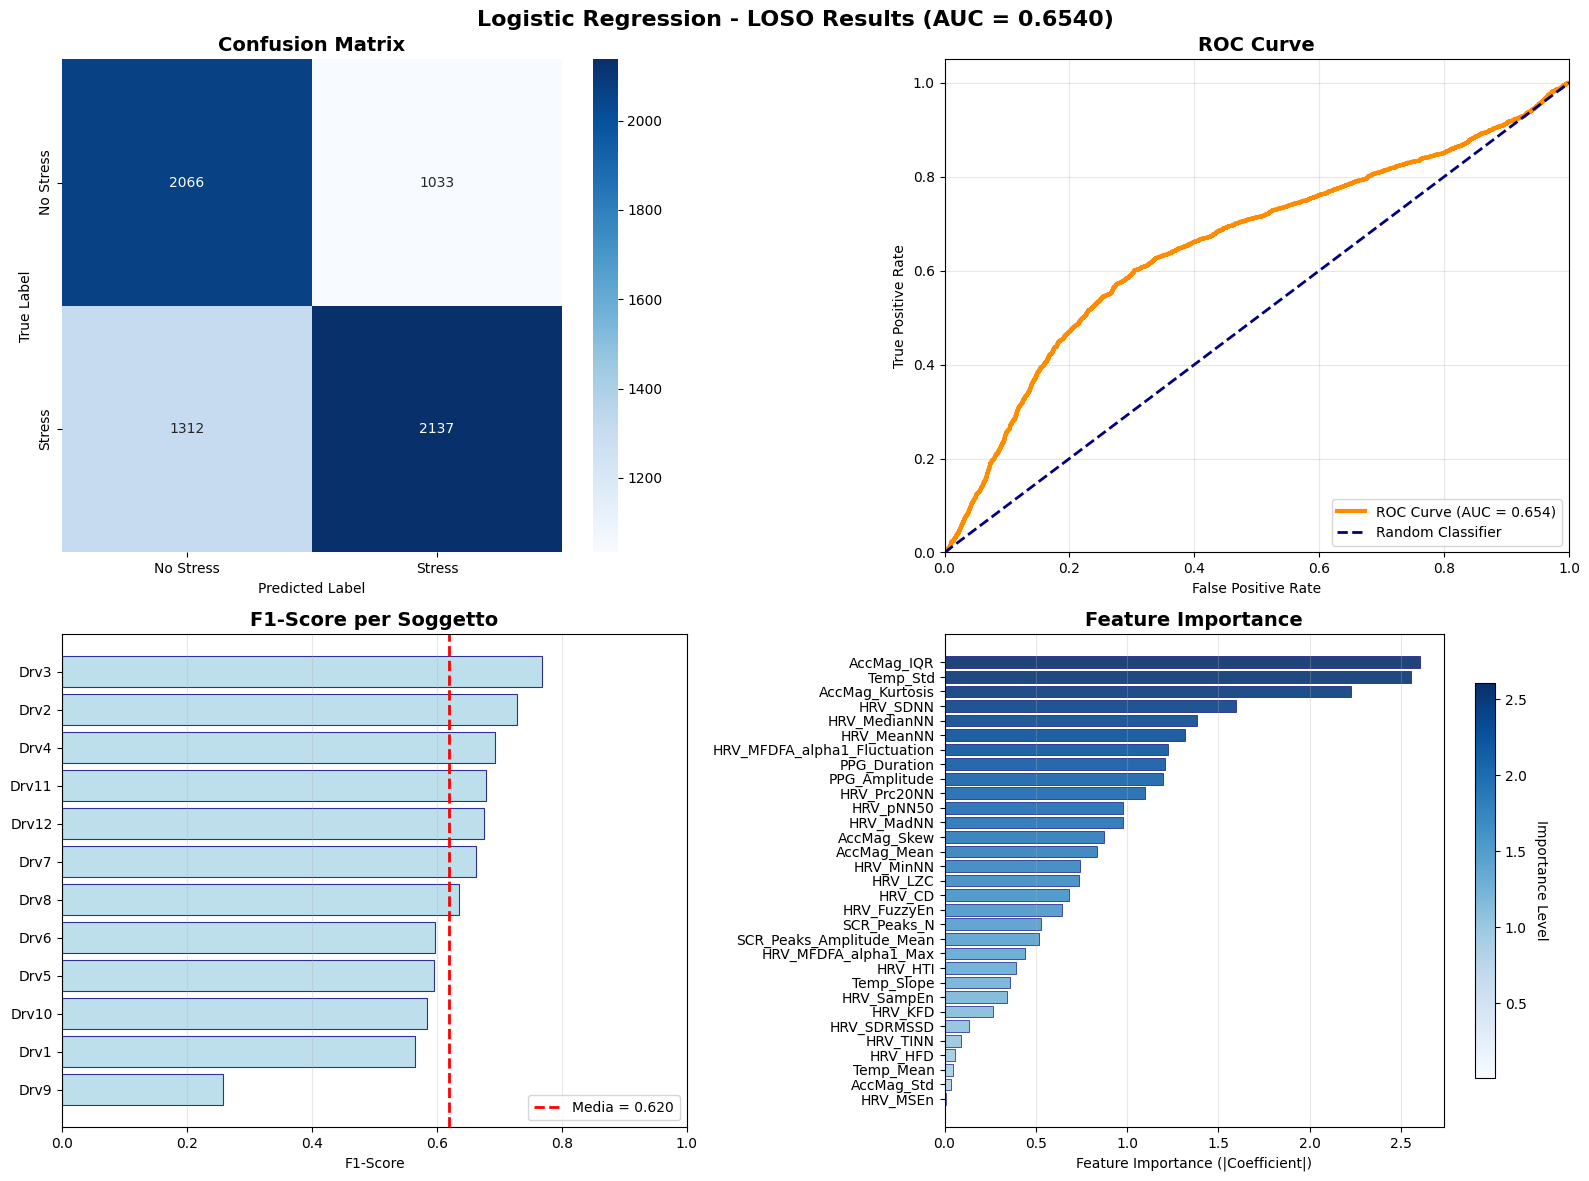


SUMMARY LOGISTIC REGRESSION LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6201 ± 0.1296
AUC globale: 0.6540
Accuratezza globale: 0.6419
Range F1-Score: 0.2571 - 0.7679
Miglior soggetto: Drv3 (F1=0.7679)
Peggiore soggetto: Drv9 (F1=0.2571)

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 6
  Soggetto test: Drv3
  F1-Score: 0.7679
  Accuracy: 0.7610
  Precision: 0.8333
  Recall: 0.7120


In [ ]:
# =============================================================================
# LOSO LOGISTIC REGRESSION CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO LOGISTIC REGRESSION ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/LOGISTIC_REGRESSION"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "logistic_regression_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "logistic_regression_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "logistic_regression_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path}")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Logistic Regression - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Palette Graduale
if final_model is not None:
    # Calcola importance in valore assoluto
    coefficients = np.abs(final_model.coef_[0])  # Valore assoluto per same direction

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': coefficients
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))  # Blues da 0.3 a 1.0 per evitare colori troppo chiari

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (|Coefficient|)')
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY LOGISTIC REGRESSION LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

RANDOM FOREST

=== LOSO RANDOM FOREST ===
Samples: 6548, Features: 31, Subjects: 12

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - Drv1: F1=0.527 Acc=0.572
 *** NUOVO BEST MODEL (F1=0.5271) ***  Fold  2 - Drv10: F1=0.598 Acc=0.602
 *** NUOVO BEST MODEL (F1=0.5977) ***  Fold  3 - Drv11: F1=0.499 Acc=0.659
  Fold  4 - Drv12: F1=0.531 Acc=0.598
  Fold  5 - Drv2: F1=0.679 Acc=0.708
 *** NUOVO BEST MODEL (F1=0.6790) ***  Fold  6 - Drv3: F1=0.755 Acc=0.745
 *** NUOVO BEST MODEL (F1=0.7547) ***  Fold  7 - Drv4: F1=0.628 Acc=0.613
  Fold  8 - Drv5: F1=0.592 Acc=0.553
  Fold  9 - Drv6: F1=0.622 Acc=0.572
  Fold 10 - Drv7: F1=0.591 Acc=0.616
  Fold 11 - Drv8: F1=0.581 Acc=0.555
  Fold 12 - Drv9: F1=0.351 Acc=0.537

--------------------------------------------------
SALVATAGGIO MIGLIOR MODELLO
--------------------------------------------------
Miglior modello salvato:
  Model: /content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/RANDOM_FOREST/random_forest_best_loso_model.pkl (scikit-learn model 

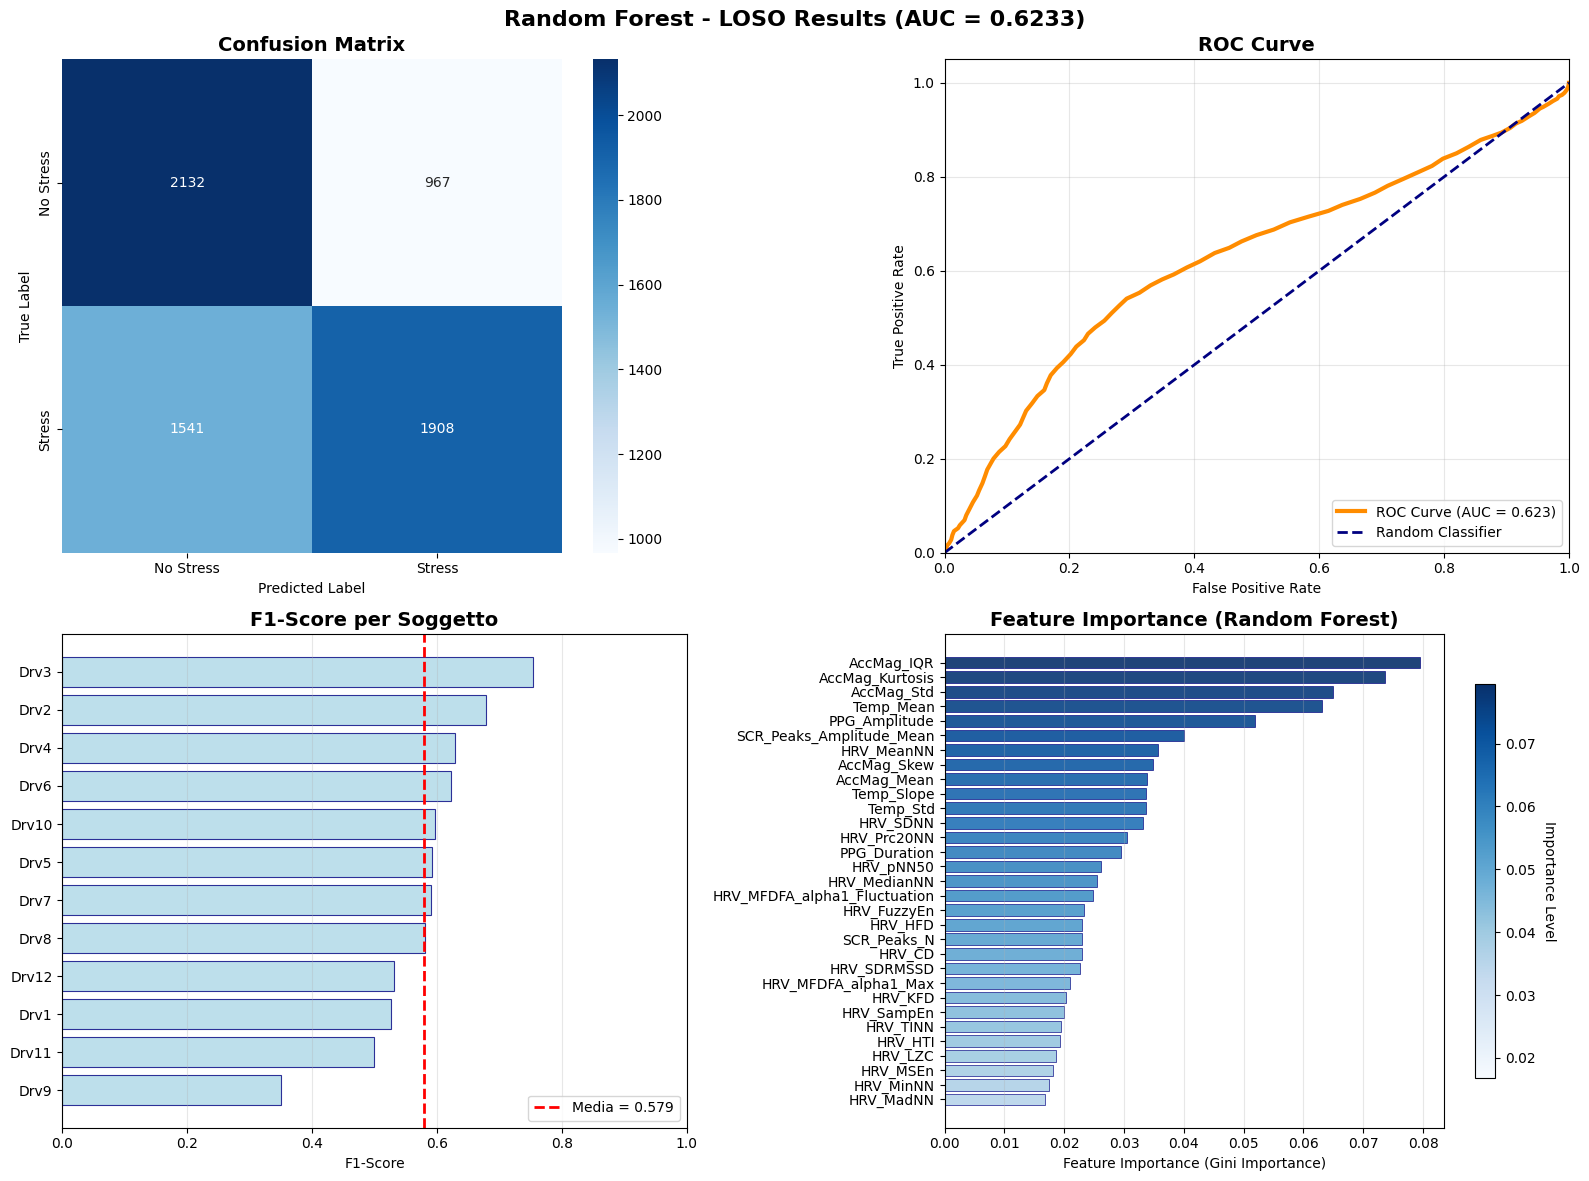


SUMMARY RANDOM FOREST LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.5794 ± 0.0997
AUC globale: 0.6233
Accuratezza globale: 0.6170
Range F1-Score: 0.3509 - 0.7547
Miglior soggetto: Drv3 (F1=0.7547)
Peggiore soggetto: Drv9 (F1=0.3509)

Parametri Random Forest:
N. estimatori: 100
Profondità massima: None
Features per split: sqrt
Criterio: gini

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 6
  Soggetto test: Drv3
  F1-Score: 0.7547
  Accuracy: 0.7452
  Precision: 0.8109
  Recall: 0.7057


In [ ]:
# =============================================================================
# LOSO RANDOM FOREST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO RANDOM FOREST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/RANDOM_FOREST"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Model training
    model = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1  # Parallelizzazione per velocità
    )

    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello (Random Forest non ha bisogno di scaler)
    import joblib
    model_path = os.path.join(save_dir, "random_forest_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "random_forest_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (scikit-learn model saved as .pkl)")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")
    print(f"  Note: Random Forest non richiede scaler separato")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Random Forest - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Random Forest Importance
if final_model is not None:
    # Calcola feature importance dal Random Forest
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gini Importance)')
    axes[1,1].set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY RANDOM FOREST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Random Forest:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Features per split: {final_model.max_features}")
    print(f"Criterio: {final_model.criterion}")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

GRADIENT BOOSTING CLASSIFIER

=== LOSO GRADIENT BOOSTING ===
Samples: 6548, Features: 31, Subjects: 12

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - Drv1: F1=0.556 Acc=0.619
 *** NUOVO BEST MODEL (F1=0.5558) ***  Fold  2 - Drv10: F1=0.601 Acc=0.581
 *** NUOVO BEST MODEL (F1=0.6007) ***  Fold  3 - Drv11: F1=0.575 Acc=0.670
  Fold  4 - Drv12: F1=0.571 Acc=0.611
  Fold  5 - Drv2: F1=0.653 Acc=0.677
 *** NUOVO BEST MODEL (F1=0.6534) ***  Fold  6 - Drv3: F1=0.763 Acc=0.736
 *** NUOVO BEST MODEL (F1=0.7627) ***  Fold  7 - Drv4: F1=0.654 Acc=0.642
  Fold  8 - Drv5: F1=0.614 Acc=0.561
  Fold  9 - Drv6: F1=0.686 Acc=0.587
  Fold 10 - Drv7: F1=0.617 Acc=0.630
  Fold 11 - Drv8: F1=0.542 Acc=0.525
  Fold 12 - Drv9: F1=0.222 Acc=0.475

--------------------------------------------------
SALVATAGGIO MIGLIOR MODELLO
--------------------------------------------------
Miglior modello salvato:
  Model: /content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/GRADIENT_BOOSTING/gradient_boosting_best_loso_model.pkl (scikit-

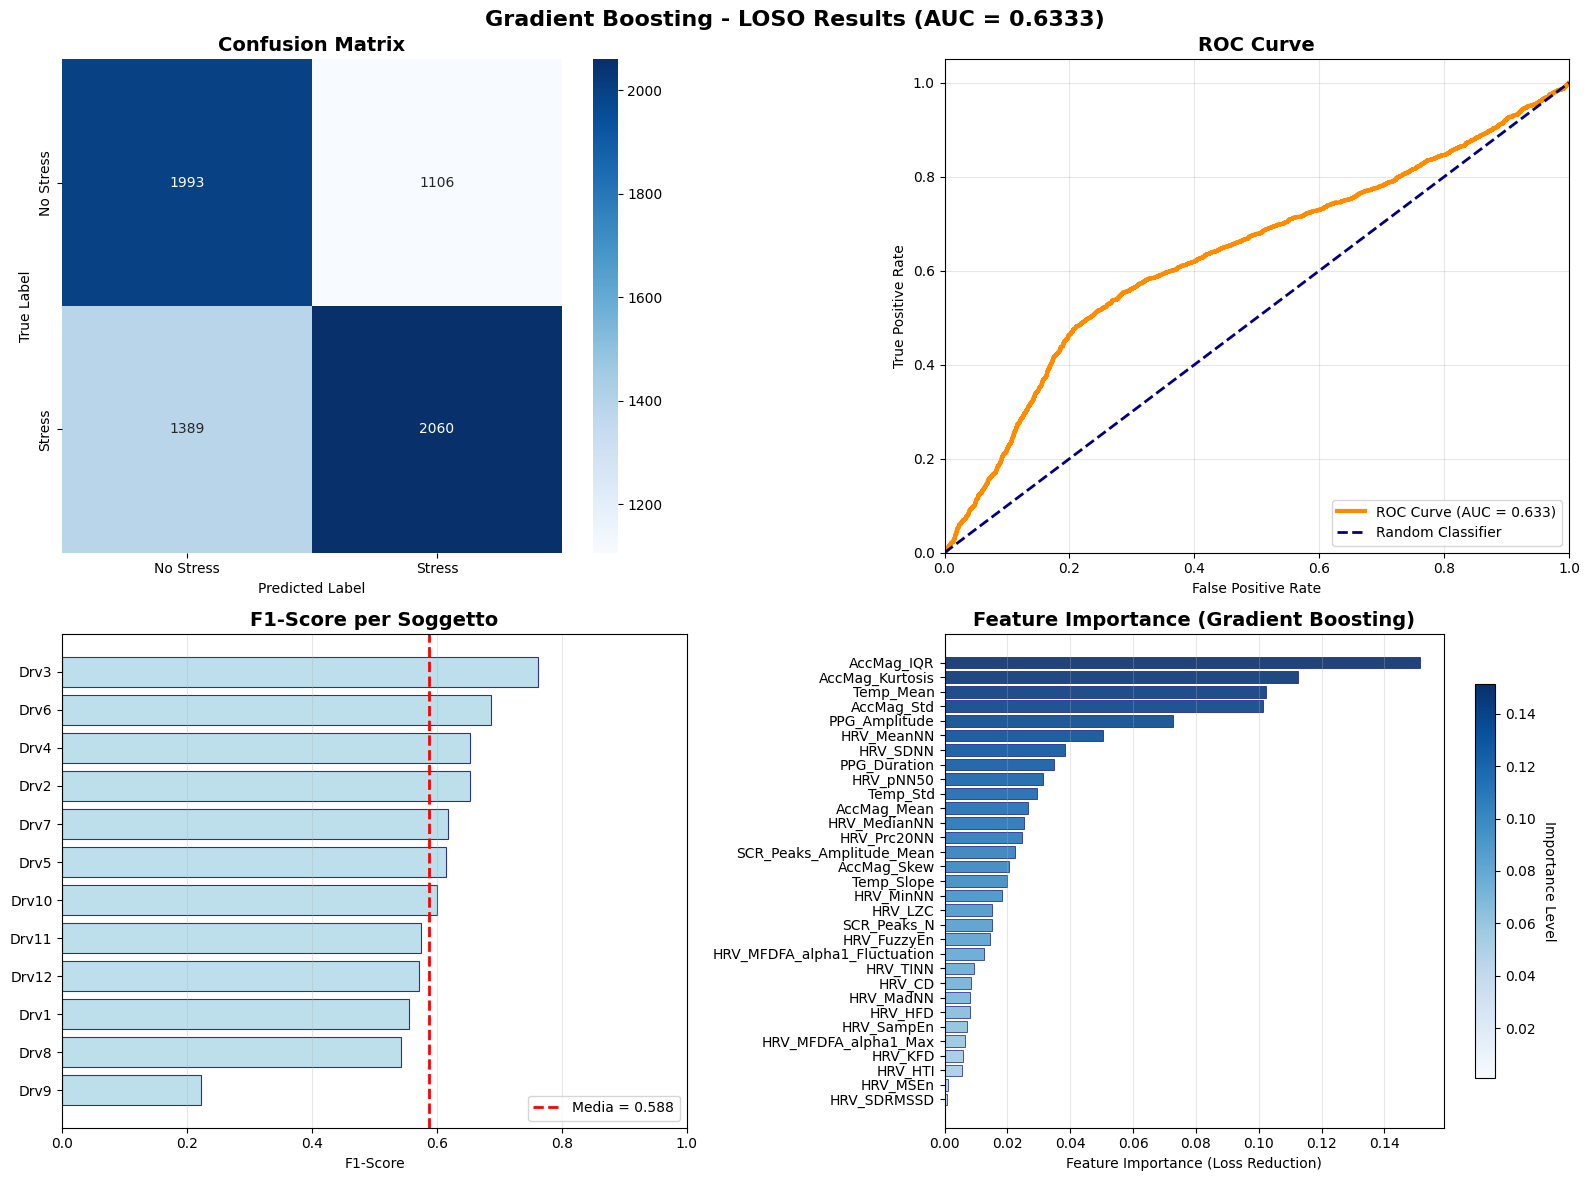


SUMMARY GRADIENT BOOSTING LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.5878 ± 0.1307
AUC globale: 0.6333
Accuratezza globale: 0.6190
Range F1-Score: 0.2222 - 0.7627
Miglior soggetto: Drv3 (F1=0.7627)
Peggiore soggetto: Drv9 (F1=0.2222)

Parametri Gradient Boosting:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
N. estimatori effettivi: 100
Training score finale: 0.9161

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 6
  Soggetto test: Drv3
  F1-Score: 0.7627
  Accuracy: 0.7364
  Precision: 0.7627
  Recall: 0.7627


In [ ]:
# =============================================================================
# LOSO GRADIENT BOOSTING CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO GRADIENT BOOSTING ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/GRADIENT_BOOSTING"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (importante per Gradient Boosting)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        max_features='sqrt',
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=5,
        tol=1e-4
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "gradient_boosting_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "gradient_boosting_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "gradient_boosting_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (scikit-learn model saved as .pkl)")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Gradient Boosting - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - Gradient Boosting Importance
if final_model is not None:
    # Calcola feature importance dal Gradient Boosting
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Loss Reduction)')
    axes[1,1].set_title('Feature Importance (Gradient Boosting)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY GRADIENT BOOSTING LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello
if final_model is not None:
    print(f"\nParametri Gradient Boosting:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"N. estimatori effettivi: {final_model.n_estimators_}")

    # Informazioni training
    if hasattr(final_model, 'train_score_'):
        print(f"Training score finale: {final_model.train_score_[-1]:.4f}")
    if hasattr(final_model, 'validation_scores_'):
        print(f"Validation score finale: {final_model.validation_scores_[-1]:.4f}")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

XGB CLASSIFIER

=== LOSO XGBOOST ===
Samples: 6548, Features: 31, Subjects: 12

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - Drv1: F1=0.535 Acc=0.609
 *** NUOVO BEST MODEL (F1=0.5354) ***  Fold  2 - Drv10: F1=0.622 Acc=0.613
 *** NUOVO BEST MODEL (F1=0.6216) ***  Fold  3 - Drv11: F1=0.559 Acc=0.646
  Fold  4 - Drv12: F1=0.577 Acc=0.618
  Fold  5 - Drv2: F1=0.669 Acc=0.693
 *** NUOVO BEST MODEL (F1=0.6691) ***  Fold  6 - Drv3: F1=0.781 Acc=0.754
 *** NUOVO BEST MODEL (F1=0.7806) ***  Fold  7 - Drv4: F1=0.628 Acc=0.595
  Fold  8 - Drv5: F1=0.619 Acc=0.571
  Fold  9 - Drv6: F1=0.701 Acc=0.597
  Fold 10 - Drv7: F1=0.651 Acc=0.655
  Fold 11 - Drv8: F1=0.575 Acc=0.546
  Fold 12 - Drv9: F1=0.321 Acc=0.525

--------------------------------------------------
SALVATAGGIO MIGLIOR MODELLO
--------------------------------------------------
Miglior modello salvato:
  Model: /content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/XGB/xgb_best_loso_model.pkl (XGBoost model saved as .pkl)
  Scaler: /conte

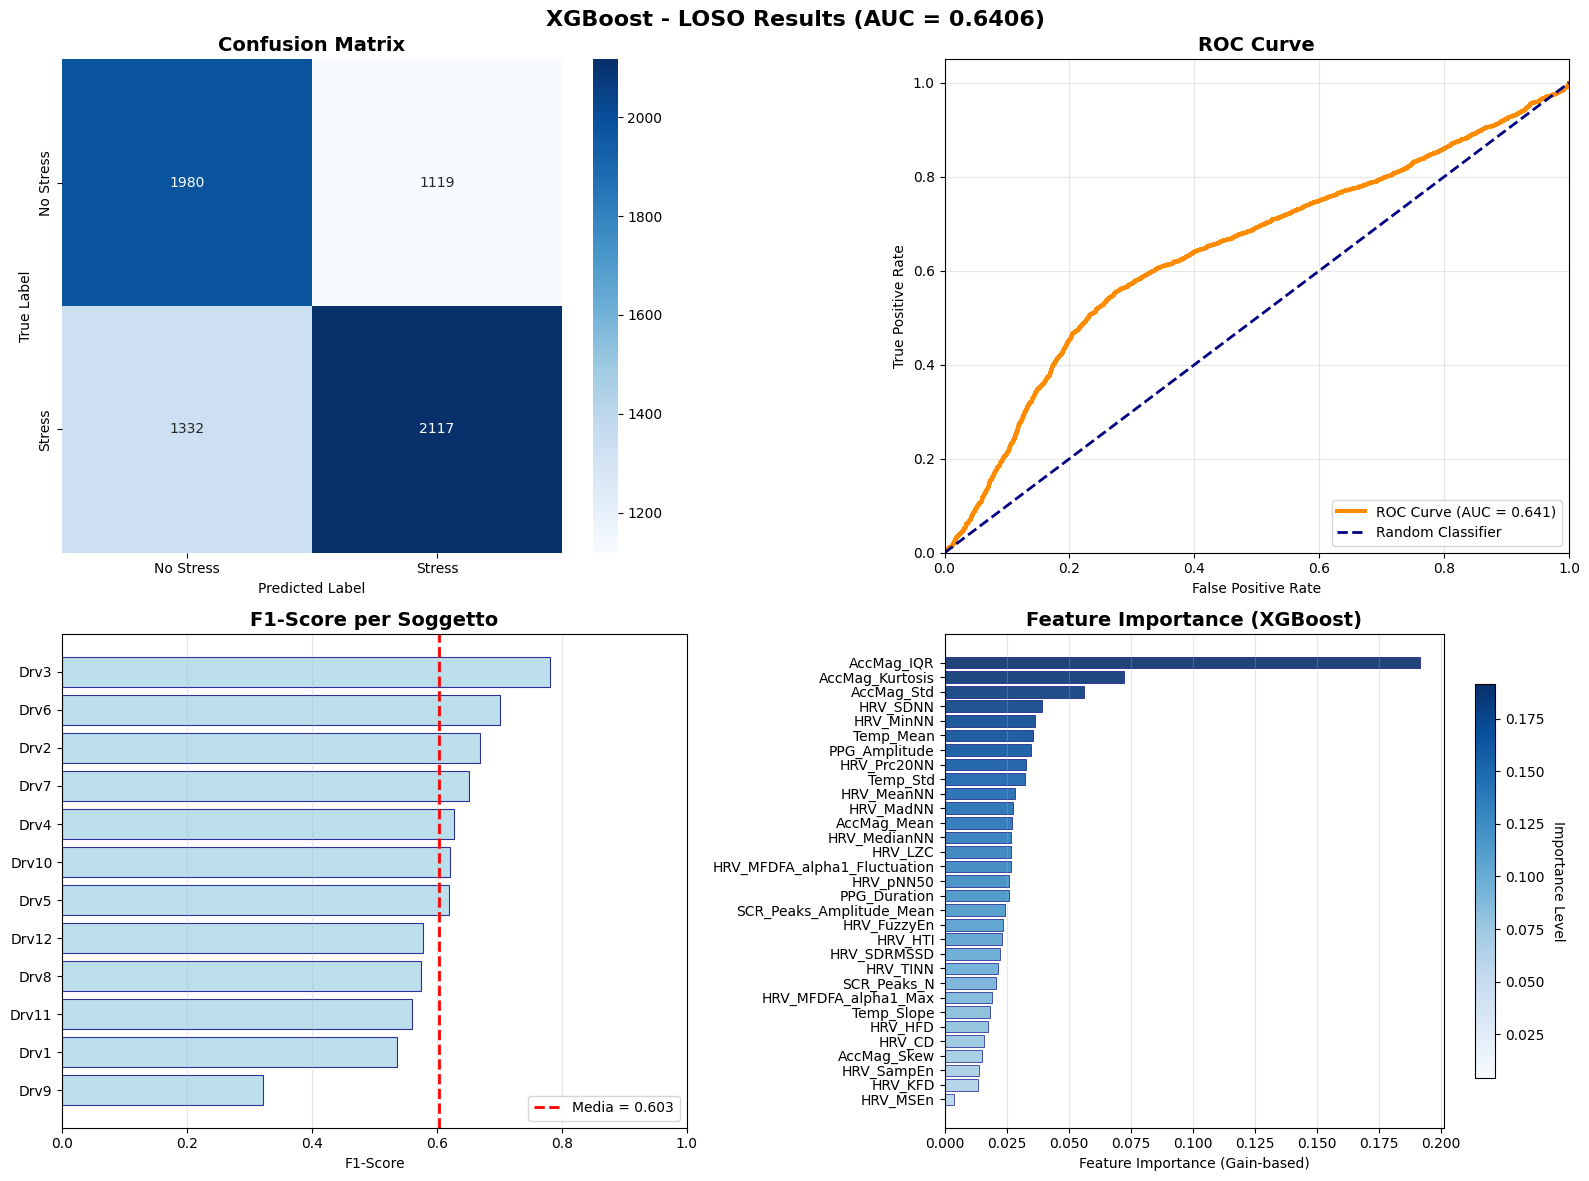


SUMMARY XGBOOST LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6033 ± 0.1113
AUC globale: 0.6406
Accuratezza globale: 0.6257
Range F1-Score: 0.3214 - 0.7806
Miglior soggetto: Drv3 (F1=0.7806)
Peggiore soggetto: Drv9 (F1=0.3214)

Parametri XGBoost:
N. estimatori: 100
Learning rate: 0.1
Profondità massima: 3
Subsample: 0.8
Colsample bytree: 0.8
Obiettivo: binary:logistic
Booster: None

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 6
  Soggetto test: Drv3
  F1-Score: 0.7806
  Accuracy: 0.7540
  Precision: 0.7733
  Recall: 0.7880


In [ ]:
# =============================================================================
# LOSO XGBOOST CON VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO XGBOOST ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None  # Per feature importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/XGB"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (XGBoost può beneficiare dello scaling)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model for feature importance
    final_model = model

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "xgb_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "xgb_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "xgb_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (XGBoost model saved as .pkl)")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'XGBoost - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - XGBoost Importance
if final_model is not None:
    # XGBoost ha diversi tipi di importance, usiamo 'weight' (numero di split)
    feature_importance = final_model.feature_importances_

    # Crea DataFrame ordinato per importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values(by='importance', ascending=True)

    # Plot con colori graduali basati sull'importanza (palette blu scura)
    colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

    bars = axes[1,1].barh(range(len(importance_df)),
                          importance_df['importance'],
                          color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

    # Configura assi
    axes[1,1].set_yticks(range(len(importance_df)))
    axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
    axes[1,1].set_xlabel('Feature Importance (Gain-based)')
    axes[1,1].set_title('Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Aggiungi colorbar per scala importance
    sm = plt.cm.ScalarMappable(cmap='Blues',
                               norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                vmax=importance_df['importance'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
    cbar.set_label('Importance Level', rotation=270, labelpad=15)

    print(f"Top 5 features più importanti:")
    top_features = importance_df.tail(5)[['feature', 'importance']]
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

    # Statistiche feature importance
    print(f"\nStatistiche Feature Importance:")
    print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
    print(f"Importanza media: {feature_importance.mean():.4f}")
    print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

    # Informazioni aggiuntive XGBoost specifiche
    try:
        # Prova ad ottenere diversi tipi di importance
        importance_types = ['weight', 'gain', 'cover']
        print(f"\nTipi di importance XGBoost disponibili:")
        booster = final_model.get_booster()
        for imp_type in importance_types:
            try:
                importance_dict = booster.get_score(importance_type=imp_type)
                if importance_dict:
                    max_feature = max(importance_dict, key=importance_dict.get)
                    print(f"  {imp_type}: {max_feature} = {importance_dict[max_feature]:.4f}")
            except:
                continue
    except:
        pass

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY XGBOOST LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello XGBoost
if final_model is not None:
    print(f"\nParametri XGBoost:")
    print(f"N. estimatori: {final_model.n_estimators}")
    print(f"Learning rate: {final_model.learning_rate}")
    print(f"Profondità massima: {final_model.max_depth}")
    print(f"Subsample: {final_model.subsample}")
    print(f"Colsample bytree: {final_model.colsample_bytree}")

    # Informazioni training specifiche XGBoost
    try:
        print(f"Obiettivo: {final_model.objective}")
        print(f"Booster: {final_model.booster}")
    except:
        pass

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

SVM CLASSIFIER

=== LOSO SVM ===
Samples: 6548, Features: 31, Subjects: 12

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - Drv1: F1=0.582 Acc=0.628
 *** NUOVO BEST MODEL (F1=0.5823) ***  Fold  2 - Drv10: F1=0.606 Acc=0.615
 *** NUOVO BEST MODEL (F1=0.6055) ***  Fold  3 - Drv11: F1=0.613 Acc=0.751
 *** NUOVO BEST MODEL (F1=0.6131) ***  Fold  4 - Drv12: F1=0.602 Acc=0.668
  Fold  5 - Drv2: F1=0.700 Acc=0.740
 *** NUOVO BEST MODEL (F1=0.7004) ***  Fold  6 - Drv3: F1=0.772 Acc=0.754
 *** NUOVO BEST MODEL (F1=0.7720) ***  Fold  7 - Drv4: F1=0.634 Acc=0.622
  Fold  8 - Drv5: F1=0.562 Acc=0.527
  Fold  9 - Drv6: F1=0.592 Acc=0.534
  Fold 10 - Drv7: F1=0.622 Acc=0.634
  Fold 11 - Drv8: F1=0.650 Acc=0.606
  Fold 12 - Drv9: F1=0.339 Acc=0.512

--------------------------------------------------
SALVATAGGIO MIGLIOR MODELLO
--------------------------------------------------
Miglior modello salvato:
  Model: /content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/SVM/svm_best_loso_model.pkl (SVM model sa

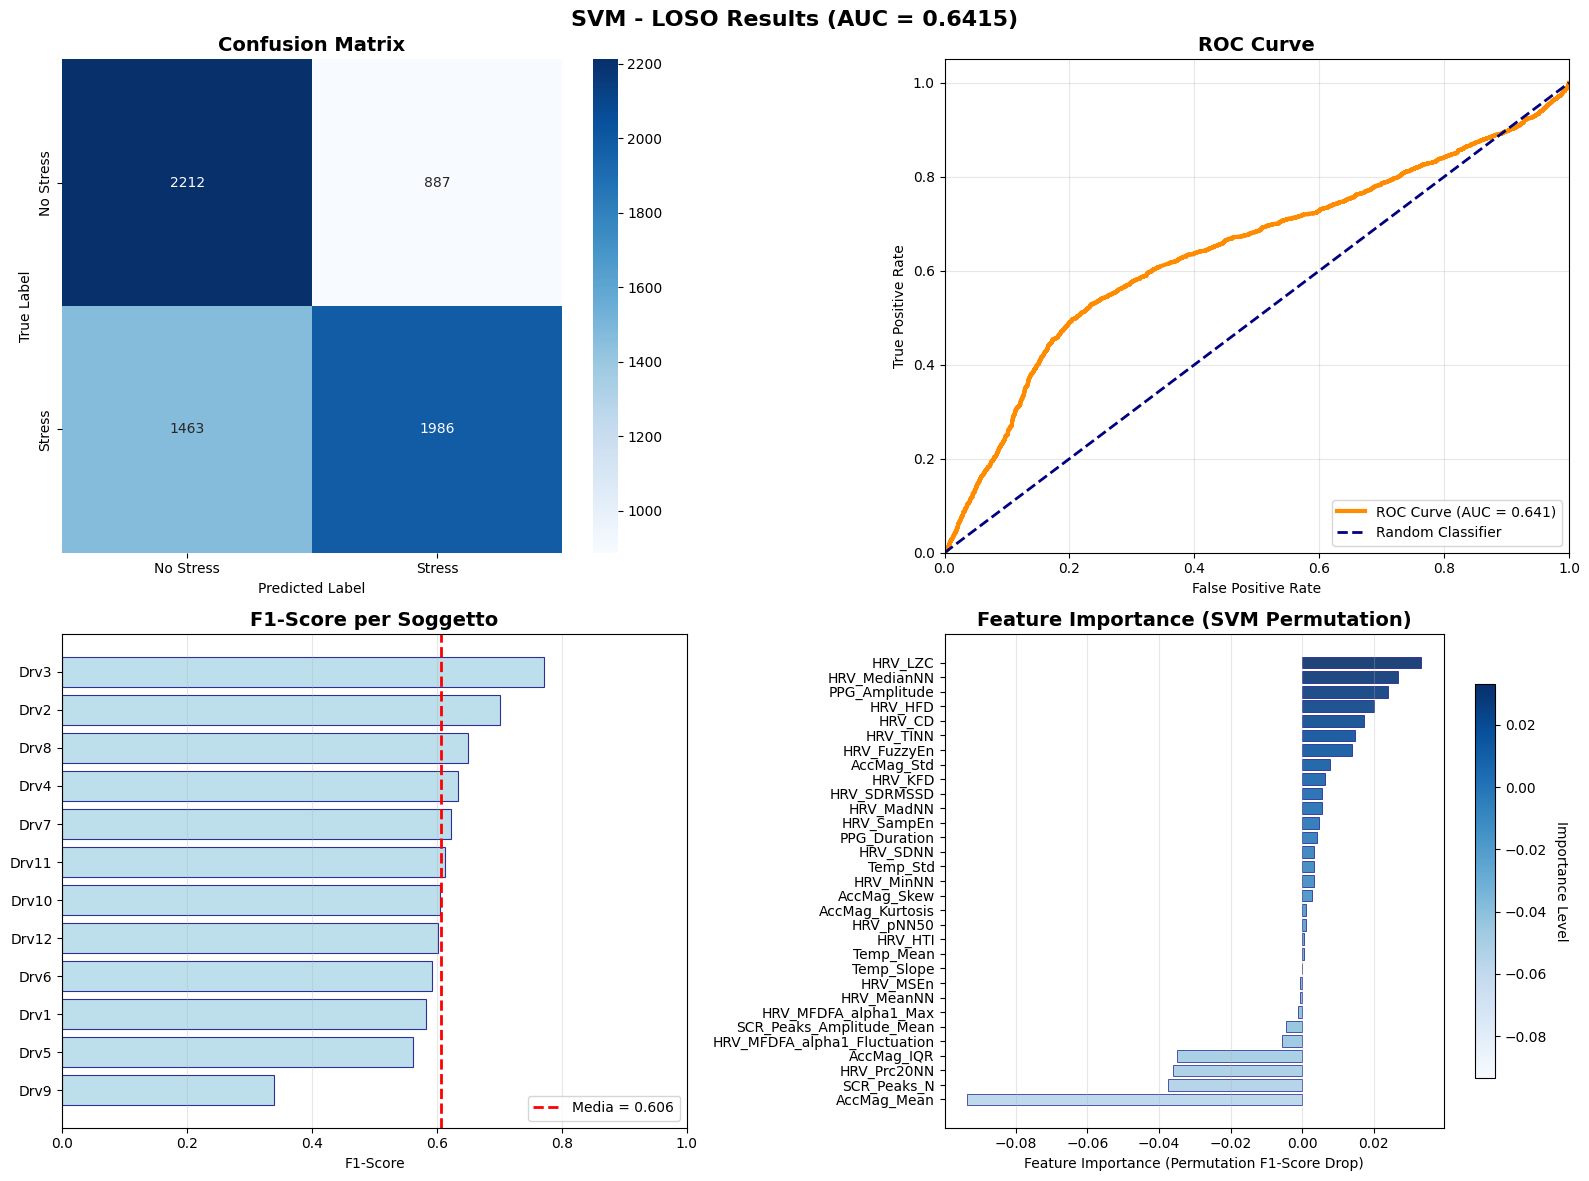


SUMMARY SVM LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6063 ± 0.1016
AUC globale: 0.6415
Accuratezza globale: 0.6411
Range F1-Score: 0.3390 - 0.7720
Miglior soggetto: Drv3 (F1=0.7720)
Peggiore soggetto: Drv9 (F1=0.3390)

Parametri SVM:
Kernel: rbf
C (regularization): 1.0
Gamma: scale
Class weight: balanced
N. support vectors: [2074 2289]
N. support vectors per classe: {np.int64(0): np.int32(2074), np.int64(1): np.int32(2289)}
Ratio support vectors: 5453.75%

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 6
  Soggetto test: Drv3
  F1-Score: 0.7720
  Accuracy: 0.7540
  Precision: 0.7953
  Recall: 0.7500


In [ ]:
# =============================================================================
# LOSO SVM CON VISUALIZZAZIONI COMPLETE E SALVATAGGIO BEST MODEL
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

print("=== LOSO SVM ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI COMPLETA E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []
final_model = None
final_X_test = None  # Per calcolo permutation importance

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/SVM"
os.makedirs(save_dir, exist_ok=True)

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per SVM)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model training
    model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Necessario per predict_proba
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"F1={f1:.3f} Acc={acc:.3f}")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model  # Salva il modello corrente
        best_scaler = scaler  # Salva lo scaler corrente
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    # Keep final model and test data for feature importance
    final_model = model
    final_X_test = X_test_scaled
    final_y_test = y_test

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    import joblib
    model_path = os.path.join(save_dir, "svm_best_loso_model.pkl")
    joblib.dump(best_model, model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "svm_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "svm_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path} (SVM model saved as .pkl)")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'SVM - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - SVM Permutation Importance
if final_model is not None and final_X_test is not None:
    print("Calcolo permutation importance per SVM...")

    try:
        # Calcola permutation importance (unico metodo disponibile per SVM)
        perm_importance = permutation_importance(
            final_model, final_X_test, final_y_test,
            n_repeats=10, random_state=42, scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza (palette blu scura)
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (SVM Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed',
                       ha='center', va='center', fontsize=12,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY SVM LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject} (F1={results_df['f1_score'].min():.4f})")

# Informazioni modello SVM
if final_model is not None:
    print(f"\nParametri SVM:")
    print(f"Kernel: {final_model.kernel}")
    print(f"C (regularization): {final_model.C}")
    print(f"Gamma: {final_model.gamma}")
    print(f"Class weight: {final_model.class_weight}")

    # Informazioni sui support vectors
    print(f"N. support vectors: {final_model.n_support_}")
    print(f"N. support vectors per classe: {dict(zip(final_model.classes_, final_model.n_support_))}")
    if final_X_test is not None:
        support_vector_ratio = final_model.support_vectors_.shape[0] / len(final_X_test)
        print(f"Ratio support vectors: {support_vector_ratio:.2%}")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Precision: {best_model_info['precision']:.4f}")
    print(f"  Recall: {best_model_info['recall']:.4f}")

print(f"{'='*60}")

MLP (BEST MODEL)

=== LOSO MLP ===
Samples: 6548, Features: 31, Subjects: 12

Inizio valutazione LOSO con salvataggio best model:
  Fold  1 - Drv1: F1=0.441 Acc=0.666 (9ep)
 *** NUOVO BEST MODEL (F1=0.4413) ***
  Fold  2 - Drv10: F1=0.581 Acc=0.529 (6ep)
 *** NUOVO BEST MODEL (F1=0.5809) ***
  Fold  3 - Drv11: F1=0.595 Acc=0.696 (11ep)
 *** NUOVO BEST MODEL (F1=0.5948) ***
  Fold  4 - Drv12: F1=0.623 Acc=0.717 (8ep)
 *** NUOVO BEST MODEL (F1=0.6225) ***
  Fold  5 - Drv2: F1=0.701 Acc=0.747 (8ep)
 *** NUOVO BEST MODEL (F1=0.7012) ***
  Fold  6 - Drv3: F1=0.777 Acc=0.743 (12ep)
 *** NUOVO BEST MODEL (F1=0.7768) ***
  Fold  7 - Drv4: F1=0.634 Acc=0.604 (7ep)

  Fold  8 - Drv5: F1=0.629 Acc=0.528 (6ep)

  Fold  9 - Drv6: F1=0.674 Acc=0.574 (6ep)

  Fold 10 - Drv7: F1=0.704 Acc=0.687 (8ep)

  Fold 11 - Drv8: F1=0.663 Acc=0.593 (6ep)

  Fold 12 - Drv9: F1=0.310 Acc=0.500 (7ep)


--------------------------------------------------
SALVATAGGIO MIGLIOR MODELLO
--------------------------------------------------
Mi

Calcolo permutation importance per MLP...
Top 5 features più importanti:
  HRV_pNN50: 0.0336
  HRV_MadNN: 0.0373
  Temp_Mean: 0.0424
  AccMag_Std: 0.0426
  AccMag_IQR: 0.1495

Statistiche Permutation Importance:
Feature più importante: AccMag_IQR (0.1495)
Importanza media: 0.0174
Features con importanza > media: 11
Errore standard medio: 0.0044
Feature più stabile: HRV_SDRMSSD (std=0.0006)


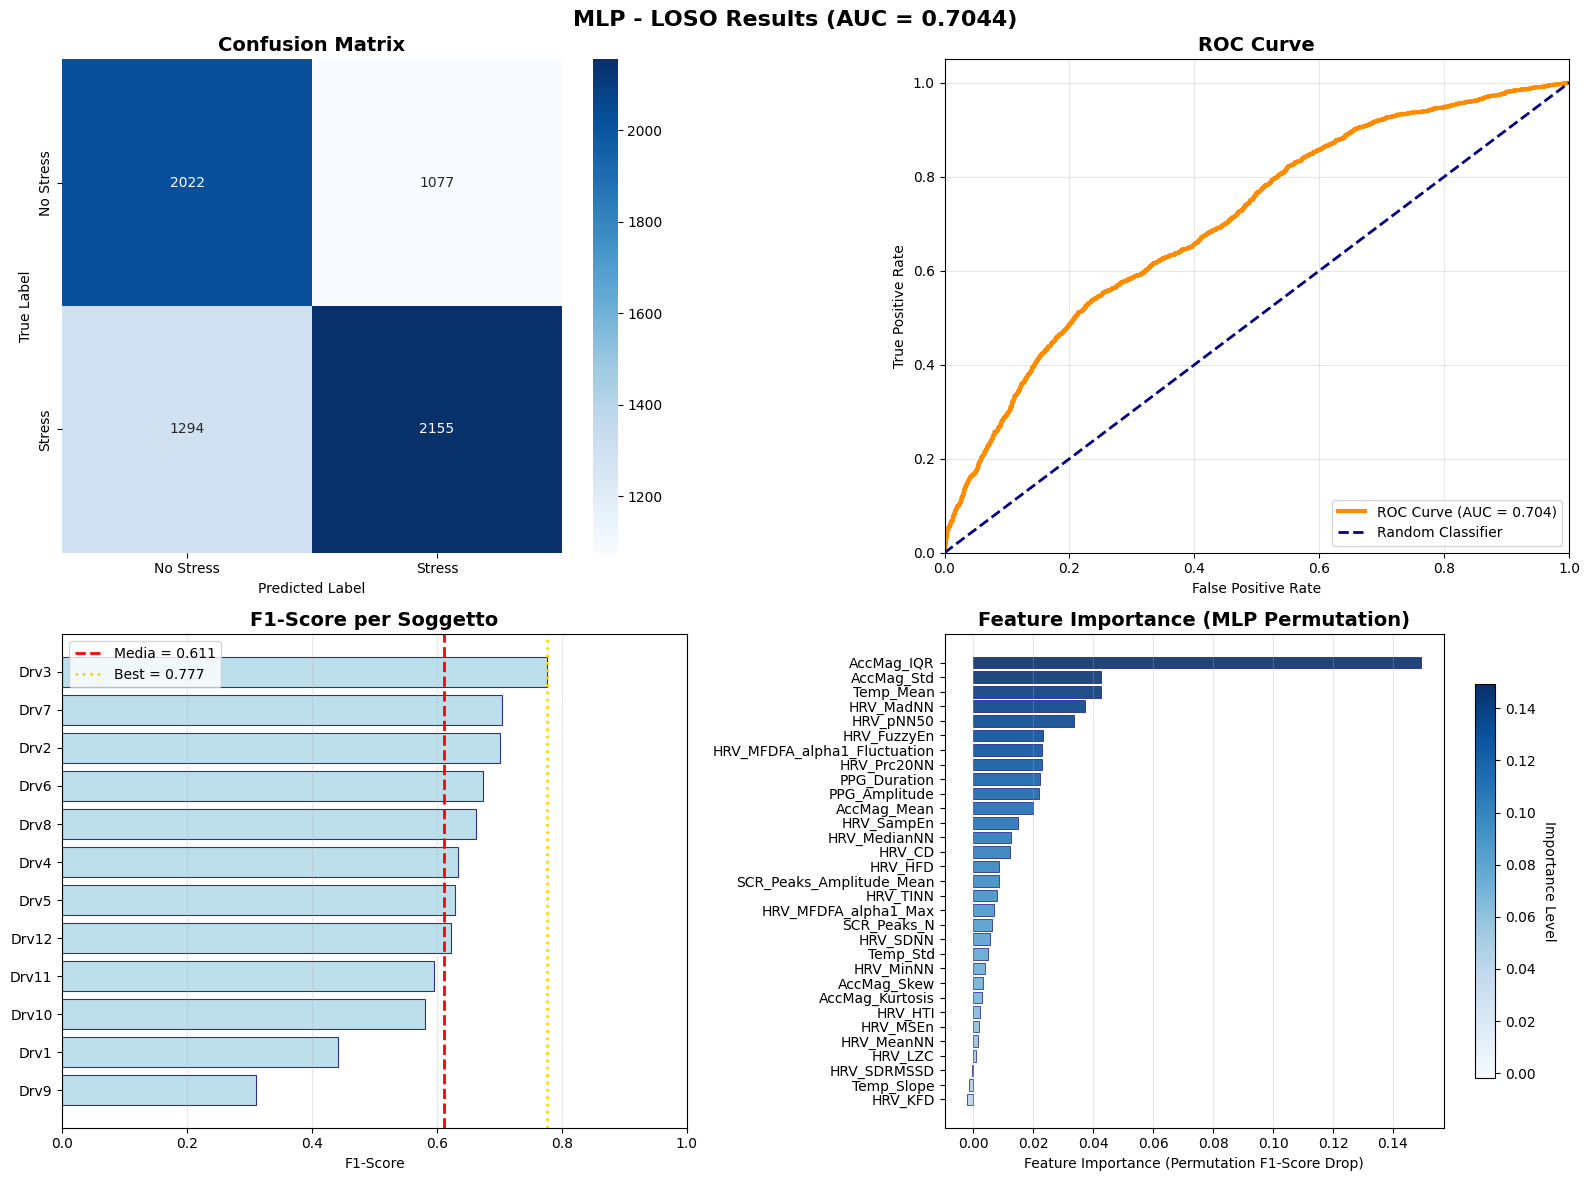


SUMMARY MLP LOSO
Dataset: 12 soggetti, 6548 campioni totali
F1-Score medio: 0.6110 ± 0.1251
AUC globale: 0.7044
Accuratezza globale: 0.6379
Range F1-Score: 0.3103 - 0.7768
Miglior soggetto: Drv3 (F1=0.7768)
Peggiore soggetto: Drv9 (F1=0.3103)
Epoche medie utilizzate: 7.8
Early stopping attivato: 12 / 12 fold

Miglior modello salvato (per cross-test/transfer learning):
  Fold: 6
  Soggetto test: Drv3
  F1-Score: 0.7768
  Accuracy: 0.7434
  Epoche utilizzate: 12


In [ ]:
# =============================================================================
# LOSO MLP CON SALVATAGGIO BEST MODEL E VISUALIZZAZIONI COMPLETE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE MODELLO MLP
# =============================================================================

def build_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))

    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# SETUP DATI E MODELLO
# =============================================================================

# Feature matrix and labels
X = df.drop(columns=['label', 'subject']).values
y = df['label'].values
groups = df['subject'].values

# Estrai nomi delle feature per visualizzazione importance
feature_names = df.drop(columns=["label", "subject"]).columns

# Setup LOSO
logo = LeaveOneGroupOut()

# Setup directory per salvataggio
save_dir = "/content/drive/MyDrive/BEST_MODELS/AFFECTIVE ROAD/MLP"
os.makedirs(save_dir, exist_ok=True)

print("=== LOSO MLP ===")
print(f"Samples: {len(X)}, Features: {X.shape[1]}, Subjects: {len(np.unique(groups))}")

# =============================================================================
# CICLO LOSO CON RACCOLTA DATI E SALVATAGGIO BEST MODEL
# =============================================================================

# Variabili per raccolta risultati
fold_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

# Variabili per tracking miglior modello
best_f1_score = 0
best_model = None
best_scaler = None
best_model_info = {}

print("\nInizio valutazione LOSO con salvataggio best model:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    subject = groups[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepare data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # Scaling (CRITICO per reti neurali)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Costruisci modello
    model = build_mlp_model(X_train_scaled.shape[1])

    # Callback per early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_prob = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    # Metrics per fold
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    epochs_used = len(history.history['loss'])
    print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep)")

    # Store results
    fold_results.append({
        'fold': fold + 1,
        'subject': subject,
        'n_samples': len(y_test),
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'epochs_used': epochs_used
    })

    # Accumulate global data
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob)
    all_subjects.extend([subject] * len(y_test))

    # Check se questo è il miglior modello
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = tf.keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())
        best_scaler = scaler
        best_model_info = {
            'fold': fold + 1,
            'subject': subject,
            'f1_score': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'epochs_used': epochs_used
        }
        print(f" *** NUOVO BEST MODEL (F1={f1:.4f}) ***", end="")

    print()  # New line

    # Pulizia memoria
    del model, history
    tf.keras.backend.clear_session()

# =============================================================================
# SALVATAGGIO MIGLIOR MODELLO
# =============================================================================

if best_model is not None:
    print(f"\n{'-'*50}")
    print("SALVATAGGIO MIGLIOR MODELLO")
    print(f"{'-'*50}")

    # Salva modello
    model_path = os.path.join(save_dir, "mlp_best_loso_model.keras")
    best_model.save(model_path)

    # Salva scaler
    scaler_path = os.path.join(save_dir, "mlp_best_loso_scaler.pkl")
    joblib.dump(best_scaler, scaler_path)

    # Salva informazioni
    import json
    info_path = os.path.join(save_dir, "mlp_best_model_info.json")
    with open(info_path, 'w') as f:
        json.dump(best_model_info, f, indent=2)

    print(f"Miglior modello salvato:")
    print(f"  Model: {model_path}")
    print(f"  Scaler: {scaler_path}")
    print(f"  Info: {info_path}")
    print(f"  F1-Score: {best_f1_score:.4f} (Fold {best_model_info['fold']}, Soggetto {best_model_info['subject']})")

# =============================================================================
# RISULTATI E STATISTICHE
# =============================================================================

print(f"\n{'-'*50}")
print("RISULTATI LOSO")
print(f"{'-'*50}")

# Results per subject
results_df = pd.DataFrame(fold_results)
print("Risultati per soggetto:")
print(results_df[['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used']].to_string(
    index=False, float_format='%.4f'))

# Aggregate statistics
print(f"\nStatistiche aggregate:")
print(f"F1-Score medio:  {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"Accuracy media:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Precision media: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"Recall medio:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
print(f"Epoche medie:    {results_df['epochs_used'].mean():.1f}")

# Global metrics
print(f"\n{'-'*50}")
print("METRICHE GLOBALI")
print(f"{'-'*50}")

# Convert to numpy arrays
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)

print("Classification Report Globale:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['No Stress', 'Stress'],
                          zero_division=0))

# Confusion Matrix
cm_global = confusion_matrix(all_y_true, all_y_pred)
print(f"\nConfusion Matrix Globale:")
print(cm_global)

# ROC AUC
fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Globale: {roc_auc:.4f}")

# =============================================================================
# VISUALIZZAZIONI COMPLETE (2x2 GRID)
# =============================================================================

print(f"\n{'-'*50}")
print("GENERAZIONE VISUALIZZAZIONI")
print(f"{'-'*50}")

# Setup figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'MLP - LOSO Results (AUC = {roc_auc:.4f})',
             fontsize=16, fontweight='bold')

# 1. CONFUSION MATRIX (Top Left) - Palette Blu
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# 2. CURVA ROC (Top Right) - Colore Arancione
axes[0,1].plot(fpr, tpr, color='darkorange', lw=3,
               label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
               label='Random Classifier')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. F1-SCORE PER SOGGETTO (Bottom Left) - Palette Blu
results_df_sorted = results_df.sort_values('f1_score', ascending=True)
bars = axes[1,0].barh(results_df_sorted['subject'],
                      results_df_sorted['f1_score'],
                      color='lightblue', alpha=0.8, edgecolor='navy', linewidth=0.8)
axes[1,0].set_xlabel('F1-Score')
axes[1,0].set_title('F1-Score per Soggetto', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Aggiungi linea media
mean_f1 = results_df['f1_score'].mean()
axes[1,0].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                  label=f'Media = {mean_f1:.3f}')

# Evidenzia miglior fold
best_fold = results_df.loc[results_df['f1_score'].idxmax()]
axes[1,0].axvline(x=best_fold['f1_score'], color='gold', linestyle=':', linewidth=2,
                  label=f'Best = {best_fold["f1_score"]:.3f}')
axes[1,0].legend()
axes[1,0].set_xlim(0, 1)

# 4. FEATURE IMPORTANCE (Bottom Right) - MLP Permutation Importance
if best_model is not None:
    print("Calcolo permutation importance per MLP...")

    try:
        # Prepara dati per permutation importance usando miglior modello
        # Usa un subset rappresentativo per velocità
        sample_size = min(500, len(all_y_true))
        sample_indices = np.random.choice(len(all_y_true), sample_size, replace=False)

        X_sample = np.array([X[i] for i in sample_indices])
        y_sample = np.array([all_y_true[i] for i in sample_indices])

        # Normalizza con best_scaler
        X_sample_scaled = best_scaler.transform(X_sample)

        # Wrapper class per sklearn compatibility
        class MLPWrapper:
            def __init__(self, model):
                self.model = model

            def fit(self, X, y):
                return self  # Dummy fit

            def predict(self, X):
                return (self.model.predict(X, verbose=0) > 0.5).astype(int).flatten()

            def score(self, X, y):
                y_pred = self.predict(X)
                return f1_score(y, y_pred, zero_division=0)

        # Crea wrapper
        mlp_wrapper = MLPWrapper(best_model)

        # Calcola permutation importance
        perm_importance = permutation_importance(
            mlp_wrapper, X_sample_scaled, y_sample,
            n_repeats=5,  # Ridotto per velocità
            random_state=42,
            scoring='f1'
        )

        feature_importance = perm_importance.importances_mean

        # Crea DataFrame ordinato per importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=True)

        # Plot con colori graduali basati sull'importanza
        colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(importance_df)))

        bars = axes[1,1].barh(range(len(importance_df)),
                              importance_df['importance'],
                              color=colors, alpha=0.9, edgecolor='navy', linewidth=0.5)

        # Configura assi
        axes[1,1].set_yticks(range(len(importance_df)))
        axes[1,1].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[1,1].set_xlabel('Feature Importance (Permutation F1-Score Drop)')
        axes[1,1].set_title('Feature Importance (MLP Permutation)', fontsize=14, fontweight='bold')
        axes[1,1].grid(True, alpha=0.3, axis='x')

        # Aggiungi colorbar per scala importance
        sm = plt.cm.ScalarMappable(cmap='Blues',
                                   norm=plt.Normalize(vmin=importance_df['importance'].min(),
                                                    vmax=importance_df['importance'].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[1,1], shrink=0.8)
        cbar.set_label('Importance Level', rotation=270, labelpad=15)

        print(f"Top 5 features più importanti:")
        top_features = importance_df.tail(5)[['feature', 'importance']]
        for _, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        # Statistiche feature importance
        print(f"\nStatistiche Permutation Importance:")
        print(f"Feature più importante: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")
        print(f"Importanza media: {feature_importance.mean():.4f}")
        print(f"Features con importanza > media: {np.sum(feature_importance > feature_importance.mean())}")

        # Errori standard della permutation importance
        importance_std = perm_importance.importances_std
        print(f"Errore standard medio: {importance_std.mean():.4f}")
        most_stable_idx = np.argmin(importance_std)
        print(f"Feature più stabile: {feature_names[most_stable_idx]} (std={importance_std[most_stable_idx]:.4f})")

    except Exception as e:
        print(f"[ERROR] Calcolo permutation importance fallito: {e}")
        axes[1,1].text(0.5, 0.5, 'Permutation Importance\nCalculation Failed\n(Computationally expensive)',
                       ha='center', va='center', fontsize=11,
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nNon Disponibile',
                   ha='center', va='center', fontsize=12,
                   transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# =============================================================================
# SUMMARY FINALE
# =============================================================================

print(f"\n{'='*60}")
print("SUMMARY MLP LOSO")
print(f"{'='*60}")
print(f"Dataset: {len(np.unique(groups))} soggetti, {len(all_y_true)} campioni totali")
print(f"F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
print(f"AUC globale: {roc_auc:.4f}")
print(f"Accuratezza globale: {accuracy_score(all_y_true, all_y_pred):.4f}")

# Range performance
print(f"Range F1-Score: {results_df['f1_score'].min():.4f} - {results_df['f1_score'].max():.4f}")
best_subject_result = results_df.loc[results_df['f1_score'].idxmax(), 'subject']
worst_subject_result = results_df.loc[results_df['f1_score'].idxmin(), 'subject']
print(f"Miglior soggetto: {best_subject_result} (F1={results_df['f1_score'].max():.4f})")
print(f"Peggiore soggetto: {worst_subject_result} (F1={results_df['f1_score'].min():.4f})")

# Informazioni training
print(f"Epoche medie utilizzate: {results_df['epochs_used'].mean():.1f}")
print(f"Early stopping attivato: {np.sum(results_df['epochs_used'] < 30)} / {len(results_df)} fold")

# Informazioni miglior modello salvato
if best_model_info:
    print(f"\nMiglior modello salvato (per cross-test/transfer learning):")
    print(f"  Fold: {best_model_info['fold']}")
    print(f"  Soggetto test: {best_model_info['subject']}")
    print(f"  F1-Score: {best_model_info['f1_score']:.4f}")
    print(f"  Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"  Epoche utilizzate: {best_model_info['epochs_used']}")

print(f"{'='*60}")

CROSS TEST E TRANSFER LEARNING

WESAD --> AFFECTIVE ROAD

WESAD CROSS TEST

In [ ]:
# =============================================================================
# CARICAMENTO MIGLIORI MODELLI WESAD E RELATIVI SCALER
# =============================================================================

import joblib
import json
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE FUNZIONI DI CARICAMENTO
# =============================================================================

def load_sklearn_model(model_dir, model_name):
    """Carica modello sklearn, scaler (opzionale) e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.pkl")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento modello (obbligatorio)
        model = joblib.load(model_path)

        # Caricamento scaler (opzionale per tree-based models)
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            scaling_required = True
        else:
            scaler = None
            scaling_required = False
            print(f"  ⚠️  {model_name.upper()}: Scaler non trovato - Tree-based model, scaling non necessario")

        # Caricamento info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

def load_keras_model(model_dir, model_name):
    """Carica modello Keras, scaler e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.keras")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)

        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

# =============================================================================
# CARICAMENTO MODELLI WESAD
# =============================================================================

print("="*60)
print("CARICAMENTO MIGLIORI MODELLI WESAD")
print("="*60)

base_dir = "/content/drive/MyDrive/BEST_MODELS/WESAD"

# Dizionario per memorizzare tutti i modelli
wesad_models = {}

# Modelli sklearn
sklearn_models = ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting']
for model_name in sklearn_models:
    model_dir = os.path.join(base_dir, model_name.upper())
    if os.path.exists(model_dir):
        model, scaler, info = load_sklearn_model(model_dir, model_name)
        if model is not None:
            wesad_models[model_name] = {
                'model': model,
                'scaler': scaler,
                'info': info,
                'type': 'sklearn'
            }

# Modello MLP (Keras)
mlp_dir = os.path.join(base_dir, "MLP")
if os.path.exists(mlp_dir):
    model, scaler, info = load_keras_model(mlp_dir, "mlp")
    if model is not None:
        wesad_models['mlp'] = {
            'model': model,
            'scaler': scaler,
            'info': info,
            'type': 'keras'
        }

print(f"\n✓ Totale modelli caricati: {len(wesad_models)}")
print("Modelli disponibili:", list(wesad_models.keys()))

# =============================================================================
# VERIFICA FEATURE COMPATIBILITY
# =============================================================================

print(f"\n{'-'*50}")
print("VERIFICA COMPATIBILITÀ FEATURE")
print(f"{'-'*50}")

# Verifica che le feature del dataset AFFECTIVE ROAD siano compatibili con WESAD
affectiveroad_features = df.drop(columns=['label', 'subject']).columns
n_affectiveroad_features = len(affectiveroad_features)

print(f"Features AFFECTIVE ROAD: {n_affectiveroad_features}")

for model_name, model_data in wesad_models.items():
    try:
        if model_data['type'] == 'sklearn':
            # Per modelli sklearn, verifica n_features_in_
            expected_features = model_data['model'].n_features_in_
        elif model_data['type'] == 'keras':
            # Per modelli Keras, verifica input_shape
            expected_features = model_data['model'].input_shape[1]

        if expected_features == n_affectiveroad_features:
            print(f"✓ {model_name.upper()}: Compatible ({expected_features} features)")
        else:
            print(f"✗ {model_name.upper()}: Incompatible - Expected: {expected_features}, Got: {n_affectiveroad_features}")

    except Exception as e:
        print(f"✗ {model_name.upper()}: Error checking compatibility - {e}")

print(f"\n{'-'*50}")
print("MODELLI PRONTI PER CROSS-TEST")
print(f"{'-'*50}")

CARICAMENTO MIGLIORI MODELLI WESAD
✓ SVM caricato - F1: 0.9821, Soggetto: S4
✓ XGB caricato - F1: 0.9821, Soggetto: S4
✓ LOGISTIC_REGRESSION caricato - F1: 0.9821, Soggetto: S4
  ⚠️  RANDOM_FOREST: Scaler non trovato - Tree-based model, scaling non necessario
✓ RANDOM_FOREST caricato - F1: 0.9630, Soggetto: S4
✓ GRADIENT_BOOSTING caricato - F1: 0.9825, Soggetto: S4
✓ MLP caricato - F1: 0.9821, Soggetto: S4

✓ Totale modelli caricati: 6
Modelli disponibili: ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting', 'mlp']

--------------------------------------------------
VERIFICA COMPATIBILITÀ FEATURE
--------------------------------------------------
Features AFFECTIVE ROAD: 31
✓ SVM: Compatible (31 features)
✓ XGB: Compatible (31 features)
✓ LOGISTIC_REGRESSION: Compatible (31 features)
✓ RANDOM_FOREST: Compatible (31 features)
✓ GRADIENT_BOOSTING: Compatible (31 features)
✓ MLP: Compatible (31 features)

--------------------------------------------------
MODELLI PR

CROSS TEST: MODELLI WESAD → DATASET AFFECTICVE ROAD
Dataset AFFECTIVE ROAD: 6548 campioni, 31 features, 12 soggetti

⚠️  SKIPPING SVM - Noto per fallimento cross-dataset

------------------------------------------------------------
CROSS-TEST: XGB
Original F1-Score WESAD: 0.9821
------------------------------------------------------------
Valutazione LOSO:
  Fold  1 - Drv1: F1=0.227 Acc=0.666
  Fold  2 - Drv10: F1=0.020 Acc=0.388
  Fold  3 - Drv11: F1=0.040 Acc=0.690
  Fold  4 - Drv12: F1=0.000 Acc=0.640
  Fold  5 - Drv2: F1=0.678 Acc=0.584
  Fold  6 - Drv3: F1=0.742 Acc=0.633
  Fold  7 - Drv4: F1=0.638 Acc=0.475
  Fold  8 - Drv5: F1=0.773 Acc=0.631
  Fold  9 - Drv6: F1=0.221 Acc=0.351
  Fold 10 - Drv7: F1=0.540 Acc=0.478
  Fold 11 - Drv8: F1=0.009 Acc=0.264
  Fold 12 - Drv9: F1=0.706 Acc=0.625

Risultati XGB:
  F1-Score medio: 0.3829 ± 0.3230
  Accuracy media: 0.5354 ± 0.1407

Classification Report Globale - XGB:
              precision    recall  f1-score   support

   No Stress     

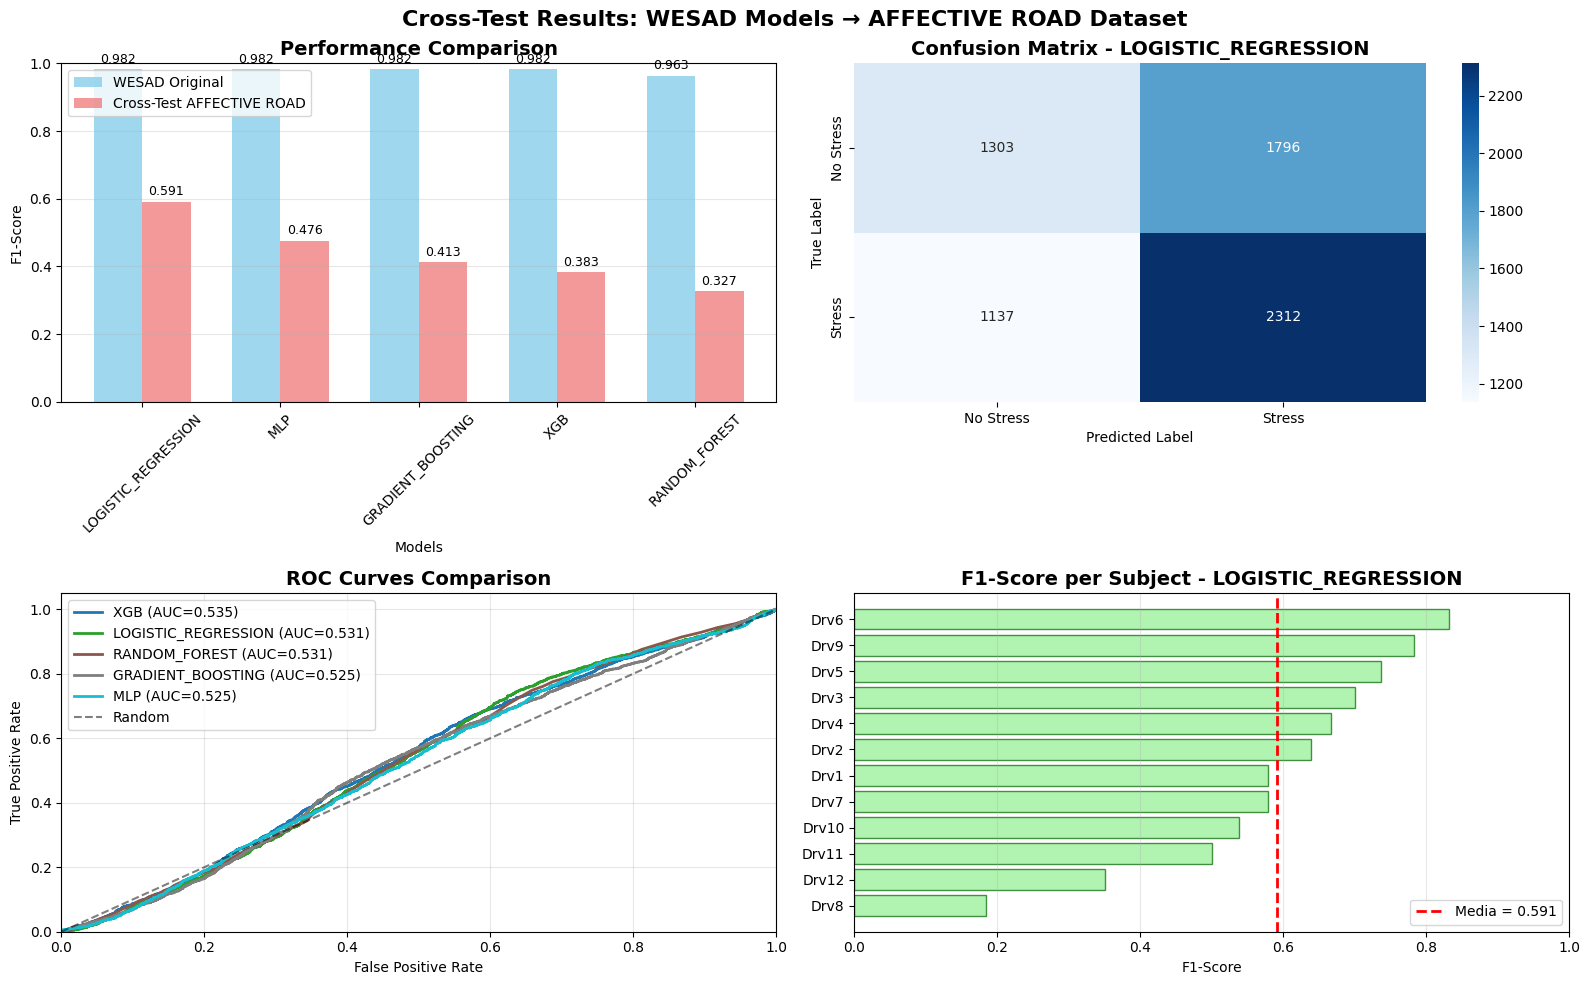


------------------------------------------------------------
ANALISI DISTRIBUZIONE PREDIZIONI
------------------------------------------------------------

XGB:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=59.36%, Stress=40.64%
  Campioni totali: 6548 (No-Stress: 3887, Stress: 2661)

LOGISTIC_REGRESSION:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=37.26%, Stress=62.74%
  Campioni totali: 6548 (No-Stress: 2440, Stress: 4108)

RANDOM_FOREST:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=66.22%, Stress=33.78%
  Campioni totali: 6548 (No-Stress: 4336, Stress: 2212)

GRADIENT_BOOSTING:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=56.63%, Stress=43.37%
  Campioni totali: 6548 (No-Stress: 3708, Stress: 2840)

MLP:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No

In [ ]:
# =============================================================================
# CROSS TEST: MODELLI WESAD → DATASET AFFECTIVE ROAD CON SOGLIA FISSA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI AFFECTIVE ROAD PER CROSS-TEST
# =============================================================================

# Prepara dati AFFECTIVE ROAD
X_affectiveroad = df.drop(columns=['label', 'subject']).values
y_affectiveroad = df['label'].values
groups_affectiveroad = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print("="*70)
print("CROSS TEST: MODELLI WESAD → DATASET AFFECTICVE ROAD")
print("="*70)
print(f"Dataset AFFECTIVE ROAD: {len(X_affectiveroad)} campioni, {X_affectiveroad.shape[1]} features, {len(np.unique(groups_affectiveroad))} soggetti")

# =============================================================================
# FUNZIONE PER CROSS-TEST CON CALIBRAZIONE SOGLIE
# =============================================================================

# =============================================================================
# FUNZIONE PER CROSS-TEST CON SOGLIA FISSA
# =============================================================================

def cross_test_model(model_name, model_data, X, y, groups, logo):
    """Esegue cross-test di un singolo modello con LOSO"""

    print(f"\n{'-'*60}")
    print(f"CROSS-TEST: {model_name.upper()}")
    print(f"Original F1-Score WESAD: {model_data['info']['f1_score']:.4f}")
    print(f"{'-'*60}")

    model = model_data['model']
    scaler = model_data['scaler']
    model_type = model_data['type']

    # Risultati per questo modello
    fold_results = []
    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    print("Valutazione LOSO:")

    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
        subject = groups[test_idx[0]]
        print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

        # Dati di test
        X_test = X[test_idx]
        y_test = y[test_idx]

        # Skip se una sola classe nel test set
        if len(np.unique(y_test)) < 2:
            print("SKIP (una sola classe)")
            continue

        # Scaling con scaler WESAD (senza refit!) - opzionale per tree-based models
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            # Per modelli tree-based che non richiedono scaling
            X_test_scaled = X_test

        try:
            # Predizione in base al tipo di modello con SOGLIA FISSA 0.5
            if model_type == 'sklearn':
                y_pred = model.predict(X_test_scaled)

                # Probabilità se disponibili
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_test_scaled)[:, 1]
                elif hasattr(model, 'decision_function'):
                    # Per SVM senza probability=True
                    decision_scores = model.decision_function(X_test_scaled)
                    # Normalizza tra 0 e 1 usando sigmoid
                    y_prob = 1 / (1 + np.exp(-decision_scores))
                else:
                    y_prob = y_pred.astype(float)  # Fallback

            elif model_type == 'keras':
                y_prob = model.predict(X_test_scaled, verbose=0).flatten()
                y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA 0.5

            # Calcola metriche
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"F1={f1:.3f} Acc={acc:.3f}")

            # Salva risultati
            fold_results.append({
                'fold': fold + 1,
                'subject': subject,
                'n_samples': len(y_test),
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

            # Accumula per metriche globali
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

        except Exception as e:
            print(f"ERROR: {e}")
            continue

    # Calcola statistiche aggregate e mostra classification report
    if fold_results:
        results_df = pd.DataFrame(fold_results)

        print(f"\nRisultati {model_name.upper()}:")
        print(f"  F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
        print(f"  Accuracy media: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")

        # CLASSIFICATION REPORT GLOBALE per questo modello
        print(f"\nClassification Report Globale - {model_name.upper()}:")
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))

        # Performance drop rispetto a WESAD
        performance_drop = model_data['info']['f1_score'] - results_df['f1_score'].mean()
        print(f"  Performance drop: {performance_drop:+.4f}")

        return {
            'model_name': model_name,
            'fold_results': fold_results,
            'results_df': results_df,
            'all_y_true': np.array(all_y_true),
            'all_y_pred': np.array(all_y_pred),
            'all_y_prob': np.array(all_y_prob),
            'original_f1': model_data['info']['f1_score'],
            'cross_test_f1': results_df['f1_score'].mean(),
            'performance_drop': performance_drop
        }
    else:
        print(f"Nessun risultato per {model_name}")
        return None

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

for model_name, model_data in wesad_models.items():
    if model_name in excluded_models:
        print(f"\n⚠️  SKIPPING {model_name.upper()} - Noto per fallimento cross-dataset")
        continue

    try:
        result = cross_test_model(model_name, model_data, X_affectiveroad, y_affectiveroad, groups_affectiveroad, logo)
        if result is not None:
            cross_test_results[model_name] = result
    except Exception as e:
        print(f"Errore generale cross-test {model_name}: {e}")
        continue

# =============================================================================
# ANALISI COMPARATIVA E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if cross_test_results:
    print(f"\n{'='*70}")
    print("ANALISI COMPARATIVA CROSS-TEST")
    print(f"{'='*70}")

    # Crea tabella comparativa
    comparison_data = []
    for model_name, result in cross_test_results.items():
        comparison_data.append({
            'Model': model_name.upper(),
            'WESAD_F1': result['original_f1'],
            'CrossTest_F1': result['cross_test_f1'],
            'Performance_Drop': result['performance_drop'],
            'N_Subjects': len(result['results_df'])
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('CrossTest_F1', ascending=False)

    print("Tabella Comparativa Performance:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))

    # Trova miglior modello cross-test
    best_model_name = comparison_df.iloc[0]['Model'].lower()
    best_result = cross_test_results[best_model_name]

    print(f"\nMiglior modello cross-test: {best_model_name.upper()}")
    print(f"F1-Score cross-test: {best_result['cross_test_f1']:.4f}")
    print(f"Performance drop: {best_result['performance_drop']:+.4f}")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (2x2 GRID)
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*50}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cross-Test Results: WESAD Models → AFFECTIVE ROAD Dataset',
                 fontsize=16, fontweight='bold')

    # 1. COMPARISON BAR CHART (Top Left)
    models = comparison_df['Model']
    wesad_scores = comparison_df['WESAD_F1']
    crosstest_scores = comparison_df['CrossTest_F1']

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[0,0].bar(x - width/2, wesad_scores, width, label='WESAD Original',
                         color='skyblue', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, crosstest_scores, width, label='Cross-Test AFFECTIVE ROAD',
                         color='lightcoral', alpha=0.8)

    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('F1-Score')
    axes[0,0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    axes[0,0].set_ylim(0, 1)

    # Aggiungi valori sulle barre
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        axes[0,0].text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                      f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0,0].text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                      f'{height2:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. CONFUSION MATRIX del miglior modello (Top Right)
    best_y_true = best_result['all_y_true']
    best_y_pred = best_result['all_y_pred']
    best_cm = confusion_matrix(best_y_true, best_y_pred)

    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0,1])
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('True Label')
    axes[0,1].set_xlabel('Predicted Label')

    # 3. ROC CURVES COMPARATIVE (Bottom Left)
    colors_roc = plt.cm.tab10(np.linspace(0, 1, len(cross_test_results)))

    for i, (model_name, result) in enumerate(cross_test_results.items()):
        if len(result['all_y_true']) > 0:
            fpr, tpr, _ = roc_curve(result['all_y_true'], result['all_y_prob'])
            roc_auc_model = auc(fpr, tpr)

            axes[1,0].plot(fpr, tpr, color=colors_roc[i], lw=2,
                          label=f'{model_name.upper()} (AUC={roc_auc_model:.3f})')

    axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. F1-SCORE DISTRIBUTION per miglior modello (Bottom Right)
    best_df = best_result['results_df'].sort_values('f1_score', ascending=True)

    bars = axes[1,1].barh(best_df['subject'], best_df['f1_score'],
                         color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1,1].set_xlabel('F1-Score')
    axes[1,1].set_title(f'F1-Score per Subject - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Linea media
    mean_f1 = best_df['f1_score'].mean()
    axes[1,1].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                     label=f'Media = {mean_f1:.3f}')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Mostra analisi bilanciamento per ogni modello
    print(f"\n{'-'*60}")
    print("ANALISI DISTRIBUZIONE PREDIZIONI")
    print(f"{'-'*60}")

    for model_name, result in cross_test_results.items():
        y_true = result['all_y_true']
        y_pred = result['all_y_pred']

        # Distribuzione reale
        true_counts = np.bincount(y_true, minlength=2)
        true_ratio = true_counts / len(y_true)

        # Distribuzione predetta
        pred_counts = np.bincount(y_pred, minlength=2)
        pred_ratio = pred_counts / len(y_pred)

        print(f"\n{model_name.upper()}:")
        print(f"  Distribuzione reale:    No-Stress={true_ratio[0]:.2%}, Stress={true_ratio[1]:.2%}")
        print(f"  Distribuzione predetta: No-Stress={pred_ratio[0]:.2%}, Stress={pred_ratio[1]:.2%}")
        print(f"  Campioni totali: {len(y_pred)} (No-Stress: {pred_counts[0]}, Stress: {pred_counts[1]})")

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Directory per salvataggio
    save_dir = "/content/drive/MyDrive/CROSS_TEST_RESULTS/WESAD_TO_AFFECTIVE ROAD"
    os.makedirs(save_dir, exist_ok=True)

    # Salva tabella comparativa
    comparison_path = os.path.join(save_dir, "wesad_to_affectiveroad_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)

    # Salva dettagli per ogni modello
    for model_name, result in cross_test_results.items():
        model_path = os.path.join(save_dir, f"{model_name}_detailed_results.csv")
        result['results_df'].to_csv(model_path, index=False)

    # Salva summary JSON
    summary = {
        'source_dataset': 'WESAD',
        'target_dataset': 'AFFECTIVE ROAD',
        'method': 'cross_test_fixed_threshold',
        'best_model': best_model_name,
        'best_crosstest_f1': float(best_result['cross_test_f1']),
        'average_performance_drop': float(comparison_df['Performance_Drop'].mean()),
        'models_tested': list(cross_test_results.keys()),
        'excluded_models': excluded_models,
        'n_subjects': len(np.unique(groups_affectiveroad))
    }

    summary_path = os.path.join(save_dir, "cross_test_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in: {save_dir}")
    print(f"  • Comparazione: {comparison_path}")
    print(f"  • Summary: {summary_path}")
    print(f"  • Dettagli per modello: {len(cross_test_results)} file CSV")

else:
    print("Nessun risultato cross-test disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("CROSS-TEST COMPLETATO!")
print(f"{'='*70}")

STRATEGIA ANTI-COLLAPSE

TRANSFER LEARNING MLP WESAD

✓ MLP WESAD caricato
  F1-Score originale: 0.9821
  Miglior soggetto: S4
  Architettura: 16 layer

TRANSFER LEARNING MLP: WESAD → AFFECTIVE ROAD
Dataset AFFECTIVE ROAD: 6548 campioni, 31 features, 12 soggetti
Parametri TL: 10 epoche max, LR=0.0001, Batch=16

Inizio Transfer Learning LOSO:
  Fold  1 - Drv1: Frozen layers: 15, Trainable: 1 F1=0.484 Acc=0.583 (10ep)
  Fold  2 - Drv10: Frozen layers: 15, Trainable: 1 F1=0.282 Acc=0.393 (10ep)
  Fold  3 - Drv11: Frozen layers: 15, Trainable: 1 F1=0.367 Acc=0.704 (10ep)
  Fold  4 - Drv12: Frozen layers: 15, Trainable: 1 F1=0.191 Acc=0.596 (10ep)
  Fold  5 - Drv2: Frozen layers: 15, Trainable: 1 F1=0.673 Acc=0.551 (10ep)
  Fold  6 - Drv3: Frozen layers: 15, Trainable: 1 F1=0.719 Acc=0.576 (10ep)
  Fold  7 - Drv4: Frozen layers: 15, Trainable: 1 F1=0.642 Acc=0.473 (10ep) [COLLAPSE]
  Fold  8 - Drv5: Frozen layers: 15, Trainable: 1 F1=0.810 Acc=0.681 (10ep)
  Fold  9 - Drv6: Frozen layers: 15, Trainable: 1 F1=0.618 Acc=0.579 (10ep)
  Fold 10 - 

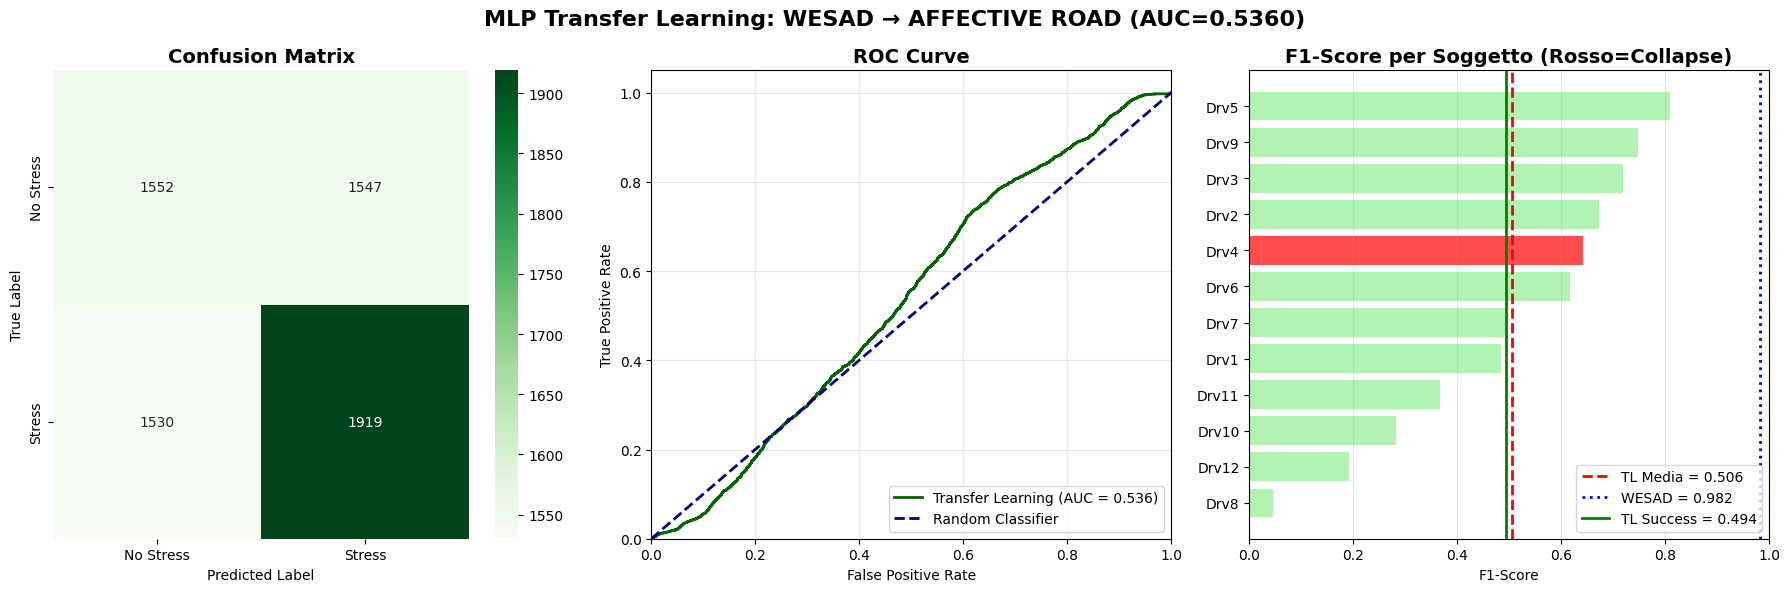


✓ Risultati salvati in:
  • Dettagli: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/WESAD_TO_AFFECTIVE ROAD/mlp_transfer_learning_results.csv
  • Summary: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/WESAD_TO_AFFECTIVE ROAD/mlp_transfer_learning_summary.json

TRANSFER LEARNING MLP COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING MLP: WESAD → AFFECTIVE ROAD (VISUALIZZAZIONI RIDOTTE)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO MLP WESAD
# =============================================================================

def load_wesad_mlp():
    """Carica il miglior modello MLP da WESAD"""
    model_dir = "/content/drive/MyDrive/BEST_MODELS/WESAD/MLP"

    model_path = os.path.join(model_dir, "mlp_best_loso_model.keras")
    scaler_path = os.path.join(model_dir, "mlp_best_loso_scaler.pkl")
    info_path = os.path.join(model_dir, "mlp_best_model_info.json")

    try:
        # Carica modello
        model = load_model(model_path)

        # Carica scaler
        scaler = joblib.load(scaler_path)

        # Carica info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ MLP WESAD caricato")
        print(f"  F1-Score originale: {info['f1_score']:.4f}")
        print(f"  Miglior soggetto: {info['subject']}")
        print(f"  Architettura: {len(model.layers)} layer")

        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento MLP WESAD: {e}")
        return None, None, None

# Carica modello MLP WESAD
wesad_mlp, wesad_scaler, wesad_info = load_wesad_mlp()

if wesad_mlp is None:
    print("[ERROR] Impossibile procedere senza modello MLP WESAD!")
    exit()

# =============================================================================
# SETUP DATI AFFECTIVE ROAD PER TRANSFER LEARNING
# =============================================================================

# Prepara dati AFFECTIVE ROAD
X_affectiveroad = df.drop(columns=['label', 'subject']).values
y_affectiveroad = df['label'].values
groups_affectiveroad = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP: WESAD → AFFECTIVE ROAD")
print(f"{'='*70}")
print(f"Dataset AFFECTIVE ROAD: {len(X_affectiveroad)} campioni, {X_affectiveroad.shape[1]} features, {len(np.unique(groups_affectiveroad))} soggetti")

# =============================================================================
# PARAMETRI TRANSFER LEARNING
# =============================================================================

# Parametri ottimali per evitare overfitting e class collapse
TL_EPOCHS = 10           # Epoche limitate per fine-tuning
TL_LR = 0.0001          # Learning rate molto basso
TL_BATCH_SIZE = 16      # Batch size piccolo
TL_PATIENCE = 5         # Patience per early stopping

print(f"Parametri TL: {TL_EPOCHS} epoche max, LR={TL_LR}, Batch={TL_BATCH_SIZE}")

# =============================================================================
# TRANSFER LEARNING LOSO
# =============================================================================

# Risultati per questo esperimento
transfer_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

print("\nInizio Transfer Learning LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_affectiveroad, y_affectiveroad, groups_affectiveroad)):
    subject = groups_affectiveroad[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepara dati
    X_train, X_test = X_affectiveroad[train_idx], X_affectiveroad[test_idx]
    y_train, y_test = y_affectiveroad[train_idx], y_affectiveroad[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # SCALING: Usa scaler WESAD su AFFECTIVE ROAD (SENZA refit)
    X_train_scaled = wesad_scaler.transform(X_train)
    X_test_scaled = wesad_scaler.transform(X_test)

    try:
        # === CLONE DEL MODELLO WESAD ===
        transfer_model = clone_model(wesad_mlp)
        transfer_model.set_weights(wesad_mlp.get_weights())

        # === CONGELA TUTTI I LAYER TRANNE L'ULTIMO ===
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False

        # Solo l'ultimo layer (classificazione) è trainable
        transfer_model.layers[-1].trainable = True

        print(f"Frozen layers: {len(transfer_model.layers)-1}, Trainable: 1", end=" ")

        # === CLASS WEIGHTS PER BILANCIAMENTO ===
        unique_classes = np.unique(y_train)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced',
                                               classes=unique_classes,
                                               y=y_train)
            class_weight_dict = dict(zip(unique_classes, class_weights))
        else:
            class_weight_dict = None

        # === COMPILA CON PARAMETRI CONSERVATIVI ===
        transfer_model.compile(
            optimizer=Adam(learning_rate=TL_LR, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # === CALLBACKS PER CONTROLLO TRAINING ===
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=TL_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=0
        )

        # === FINE-TUNING TRAINING ===
        history = transfer_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=TL_EPOCHS,
            batch_size=TL_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # === PREDIZIONI CON SOGLIA FISSA ===
        y_prob = transfer_model.predict(X_test_scaled, verbose=0).flatten()
        y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA, NESSUNA CORREZIONE

        # Verifica class collapse (solo per documentazione)
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            collapse_warning = " [COLLAPSE]"
        else:
            collapse_warning = ""

        # === CALCOLA METRICHE ===
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        epochs_used = len(history.history['loss'])
        print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep){collapse_warning}")

        # === SALVA RISULTATI (inclusa informazione sul collapse) ===
        transfer_results.append({
            'fold': fold + 1,
            'subject': subject,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': epochs_used,
            'predicted_classes': len(unique_pred),
            'class_collapsed': len(unique_pred) == 1
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        all_subjects.extend([subject] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# ANALISI RISULTATI E CONFRONTI
# =============================================================================

print(f"\n{'-'*60}")
print("RISULTATI TRANSFER LEARNING MLP")
print(f"{'-'*60}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['class_collapsed'] == True]
    successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
    success_rate = (len(successful_folds) / len(transfer_df)) * 100 if len(transfer_df) > 0 else 0

    print(f"Fold completati: {len(transfer_df)}")
    print(f"Fold con class collapse: {len(collapse_folds)}")
    print(f"Fold successful: {len(successful_folds)}")
    print(f"Success rate: {success_rate:.1f}%")

    if len(successful_folds) > 0:
        print(f"F1-Score medio (solo fold successful): {successful_folds['f1_score'].mean():.4f} ± {successful_folds['f1_score'].std():.4f}")
    else:
        print("ATTENZIONE: Nessun fold successful - transfer learning fallito")

    # Statistiche per soggetto
    print(f"\nRisultati dettagliati:")
    display_cols = ['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used', 'class_collapsed']
    print(transfer_df[display_cols].to_string(index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    # Confronto con WESAD originale
    print(f"\n{'-'*60}")
    print("CONFRONTO PERFORMANCE")
    print(f"{'-'*60}")

    wesad_f1 = wesad_info['f1_score']
    transfer_f1 = transfer_df['f1_score'].mean()
    improvement = transfer_f1 - wesad_f1
    improvement_pct = (improvement / wesad_f1) * 100

    print(f"WESAD F1-Score originale: {wesad_f1:.4f}")
    print(f"Transfer Learning F1:     {transfer_f1:.4f}")
    print(f"Miglioramento assoluto:   {improvement:+.4f}")
    print(f"Miglioramento relativo:   {improvement_pct:+.2f}%")

    # Range performance
    print(f"\nRange F1-Score: {transfer_df['f1_score'].min():.4f} - {transfer_df['f1_score'].max():.4f}")
    best_subject = transfer_df.loc[transfer_df['f1_score'].idxmax(), 'subject']
    worst_subject = transfer_df.loc[transfer_df['f1_score'].idxmin(), 'subject']
    print(f"Miglior soggetto: {best_subject} (F1={transfer_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {worst_subject} (F1={transfer_df['f1_score'].min():.4f})")

# =============================================================================
# METRICHE GLOBALI E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_prob = np.array(all_y_prob)

    print(f"\n{'-'*60}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*60}")

    # Verifica globale class collapse
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")

    if global_unique_pred == 1:
        print("⚠️ ATTENZIONE: Solo una classe predetta globalmente - Transfer Learning ha fallito!")
        predicted_class = all_y_pred[0]
        print(f"   Classe predetta: {predicted_class} ({'Stress' if predicted_class == 1 else 'No Stress'})")
        print("   Tutte le metriche saranno compromesse dal class collapse.")
    else:
        print("✅ Transfer Learning successful - Entrambe le classi predette")

    # Classification Report globale
    print("\nClassification Report Globale:")
    try:
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))
    except:
        print("Impossibile calcolare classification report a causa del class collapse")

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # ROC AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback - class collapse)")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (1x3 GRID)
    # =============================================================================

    print(f"\n{'-'*60}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*60}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'MLP Transfer Learning: WESAD → AFFECTIVE ROAD (AUC={roc_auc:.4f})',
                 fontsize=16, fontweight='bold')

    # 1. CONFUSION MATRIX (Left)
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. ROC CURVE (Middle)
    axes[1].plot(fpr, tpr, color='darkgreen', lw=2,
                 label=f'Transfer Learning (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO (Right)
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base al class collapse
        colors = ['red' if collapsed else 'lightgreen'
                 for collapsed in transfer_df_sorted['class_collapsed']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                       label=f'TL Media = {mean_f1_tl:.3f}')
        axes[2].axvline(x=wesad_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                       label=f'WESAD = {wesad_info["f1_score"]:.3f}')

        # Linea per media solo fold successful (se esistono)
        successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
        if len(successful_folds) > 0:
            mean_f1_successful = successful_folds['f1_score'].mean()
            axes[2].axvline(x=mean_f1_successful, color='green', linestyle='-', linewidth=2,
                           label=f'TL Success = {mean_f1_successful:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/WESAD_TO_AFFECTIVE ROAD"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "mlp_transfer_learning_results.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary completo
    summary = {
        'experiment': 'MLP_Transfer_Learning',
        'source_dataset': 'WESAD',
        'target_dataset': 'AFFECTIVE ROAD',
        'source_f1': float(wesad_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'performance_improvement': float(improvement),
        'improvement_percentage': float(improvement_pct),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'success_rate': float(success_rate),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'class_collapse_folds': int(len(collapse_folds)),
        'successful_folds': int(len(successful_folds)),
        'global_classes_predicted': int(global_unique_pred),
        'parameters': {
            'epochs': TL_EPOCHS,
            'learning_rate': TL_LR,
            'batch_size': TL_BATCH_SIZE,
            'patience': TL_PATIENCE
        }
    }

    summary_path = os.path.join(save_dir, "mlp_transfer_learning_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in:")
    print(f"  • Dettagli: {results_path}")
    print(f"  • Summary: {summary_path}")

else:
    print("[WARNING] Nessun risultato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP COMPLETATO!")
print(f"{'='*70}")

CAMPANELLA --> AFFECTIVE ROAD

CROSS TEST CAMPANELLA

In [ ]:
# =============================================================================
# CARICAMENTO MIGLIORI MODELLI CAMPANELLA E RELATIVI SCALER
# =============================================================================

import joblib
import json
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE FUNZIONI DI CARICAMENTO
# =============================================================================

def load_sklearn_model(model_dir, model_name):
    """Carica modello sklearn, scaler (opzionale) e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.pkl")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento modello (obbligatorio)
        model = joblib.load(model_path)

        # Caricamento scaler (opzionale per tree-based models)
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            scaling_required = True
        else:
            scaler = None
            scaling_required = False
            print(f"  ⚠️  {model_name.upper()}: Scaler non trovato - Tree-based model, scaling non necessario")

        # Caricamento info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

def load_keras_model(model_dir, model_name):
    """Carica modello Keras, scaler e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.keras")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)

        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

# =============================================================================
# CARICAMENTO MODELLI CAMPANELLA
# =============================================================================

print("="*60)
print("CARICAMENTO MIGLIORI MODELLI CAMPANELLA")
print("="*60)

base_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA"

# Dizionario per memorizzare tutti i modelli
campanella_models = {}

# Modelli sklearn
sklearn_models = ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting']
for model_name in sklearn_models:
    model_dir = os.path.join(base_dir, model_name.upper())
    if os.path.exists(model_dir):
        model, scaler, info = load_sklearn_model(model_dir, model_name)
        if model is not None:
            campanella_models[model_name] = {
                'model': model,
                'scaler': scaler,
                'info': info,
                'type': 'sklearn'
            }

# Modello MLP (Keras)
mlp_dir = os.path.join(base_dir, "MLP")
if os.path.exists(mlp_dir):
    model, scaler, info = load_keras_model(mlp_dir, "mlp")
    if model is not None:
        campanella_models['mlp'] = {
            'model': model,
            'scaler': scaler,
            'info': info,
            'type': 'keras'
        }

print(f"\n✓ Totale modelli caricati: {len(campanella_models)}")
print("Modelli disponibili:", list(campanella_models.keys()))

# =============================================================================
# VERIFICA FEATURE COMPATIBILITY
# =============================================================================

print(f"\n{'-'*50}")
print("VERIFICA COMPATIBILITÀ FEATURE")
print(f"{'-'*50}")

# Verifica che le feature del dataset AFFECTIVE ROAD siano compatibili con CAMPANELLA
affectiveroad_features = df.drop(columns=['label', 'subject']).columns
n_affectiveroad_features = len(affectiveroad_features)

print(f"Features AFFECTIVE ROAD: {n_affectiveroad_features}")

for model_name, model_data in campanella_models.items():
    try:
        if model_data['type'] == 'sklearn':
            # Per modelli sklearn, verifica n_features_in_
            expected_features = model_data['model'].n_features_in_
        elif model_data['type'] == 'keras':
            # Per modelli Keras, verifica input_shape
            expected_features = model_data['model'].input_shape[1]

        if expected_features == n_affectiveroad_features:
            print(f"✓ {model_name.upper()}: Compatible ({expected_features} features)")
        else:
            print(f"✗ {model_name.upper()}: Incompatible - Expected: {expected_features}, Got: {n_affectiveroad_features}")

    except Exception as e:
        print(f"✗ {model_name.upper()}: Error checking compatibility - {e}")

print(f"\n{'-'*50}")
print("MODELLI PRONTI PER CROSS-TEST")
print(f"{'-'*50}")

CARICAMENTO MIGLIORI MODELLI CAMPANELLA
✓ SVM caricato - F1: 0.9252, Soggetto: subject_24
✓ XGB caricato - F1: 0.9359, Soggetto: subject_23
✓ LOGISTIC_REGRESSION caricato - F1: 0.8933, Soggetto: subject_11
  ⚠️  RANDOM_FOREST: Scaler non trovato - Tree-based model, scaling non necessario
✓ RANDOM_FOREST caricato - F1: 0.9342, Soggetto: subject_23
✓ GRADIENT_BOOSTING caricato - F1: 0.9308, Soggetto: subject_23
✓ MLP caricato - F1: 0.9820, Soggetto: subject_11

✓ Totale modelli caricati: 6
Modelli disponibili: ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting', 'mlp']

--------------------------------------------------
VERIFICA COMPATIBILITÀ FEATURE
--------------------------------------------------
Features AFFECTIVE ROAD: 31
✓ SVM: Compatible (31 features)
✓ XGB: Compatible (31 features)
✓ LOGISTIC_REGRESSION: Compatible (31 features)
✓ RANDOM_FOREST: Compatible (31 features)
✓ GRADIENT_BOOSTING: Compatible (31 features)
✓ MLP: Compatible (31 features)

--------

CROSS TEST: MODELLI CAMPANELLA → DATASET AFFECTIVE ROAD
Dataset AFFECTIVE ROAD: 6548 campioni, 31 features, 12 soggetti

⚠️  SKIPPING SVM - Noto per fallimento cross-dataset

------------------------------------------------------------
CROSS-TEST: XGB
Original F1-Score CAMPANELLA: 0.9359
------------------------------------------------------------
Valutazione LOSO:
  Fold  1 - Drv1: F1=0.565 Acc=0.515
  Fold  2 - Drv10: F1=0.614 Acc=0.504
  Fold  3 - Drv11: F1=0.420 Acc=0.359
  Fold  4 - Drv12: F1=0.238 Acc=0.376
  Fold  5 - Drv2: F1=0.635 Acc=0.503
  Fold  6 - Drv3: F1=0.583 Acc=0.492
  Fold  7 - Drv4: F1=0.594 Acc=0.440
  Fold  8 - Drv5: F1=0.700 Acc=0.568
  Fold  9 - Drv6: F1=0.819 Acc=0.698
  Fold 10 - Drv7: F1=0.578 Acc=0.489
  Fold 11 - Drv8: F1=0.510 Acc=0.421
  Fold 12 - Drv9: F1=0.752 Acc=0.662

Risultati XGB:
  F1-Score medio: 0.5841 ± 0.1517
  Accuracy media: 0.5023 ± 0.1026

Classification Report Globale - XGB:
              precision    recall  f1-score   support

   No St

F1=0.532 Acc=0.438
  Fold  2 - Drv10: F1=0.593 Acc=0.462
  Fold  3 - Drv11: F1=0.476 Acc=0.334
  Fold  4 - Drv12: F1=0.535 Acc=0.413
  Fold  5 - Drv2: F1=0.668 Acc=0.520
  Fold  6 - Drv3: F1=0.707 Acc=0.578
  Fold  7 - Drv4: F1=0.638 Acc=0.471
  Fold  8 - Drv5: F1=0.794 Acc=0.661
  Fold  9 - Drv6: F1=0.826 Acc=0.708
  Fold 10 - Drv7: F1=0.757 Acc=0.634
  Fold 11 - Drv8: F1=0.776 Acc=0.639
  Fold 12 - Drv9: F1=0.621 Acc=0.450

Risultati MLP:
  F1-Score medio: 0.6602 ± 0.1141
  Accuracy media: 0.5258 ± 0.1162

Classification Report Globale - MLP:
              precision    recall  f1-score   support

   No Stress       0.53      0.09      0.16      3099
      Stress       0.53      0.92      0.67      3449

    accuracy                           0.53      6548
   macro avg       0.53      0.51      0.42      6548
weighted avg       0.53      0.53      0.43      6548

  Performance drop: +0.3219

ANALISI COMPARATIVA CROSS-TEST
Tabella Comparativa Performance:
              Model  CAMPANEL

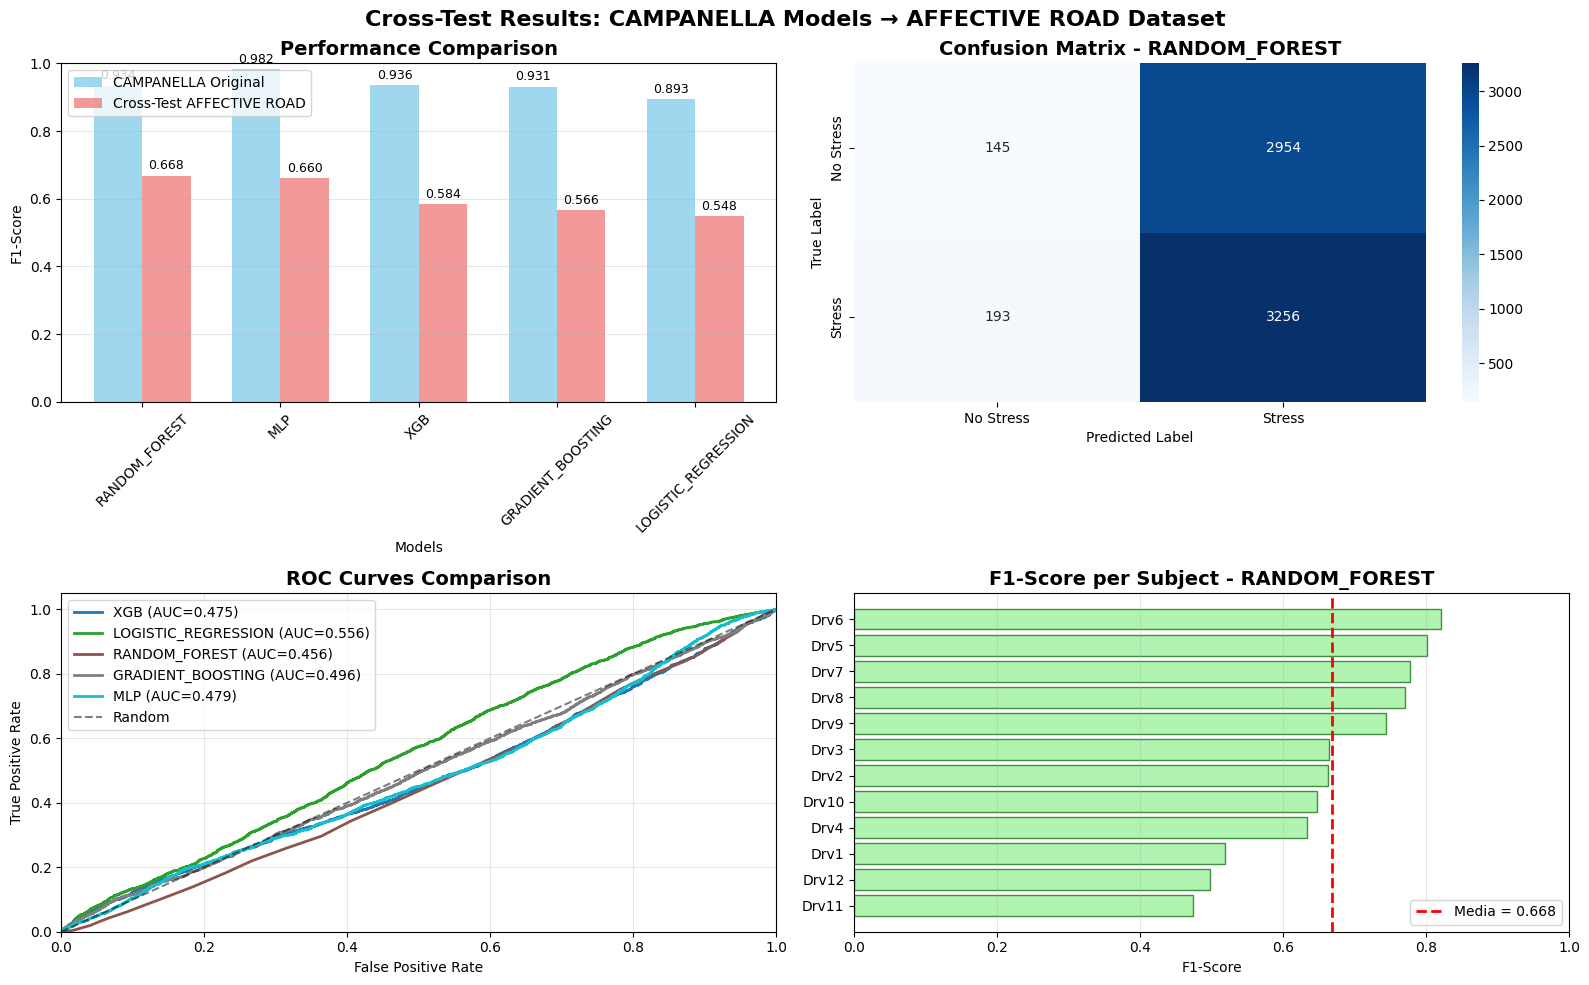


------------------------------------------------------------
ANALISI DISTRIBUZIONE PREDIZIONI
------------------------------------------------------------

XGB:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=26.62%, Stress=73.38%
  Campioni totali: 6548 (No-Stress: 1743, Stress: 4805)

LOGISTIC_REGRESSION:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=45.28%, Stress=54.72%
  Campioni totali: 6548 (No-Stress: 2965, Stress: 3583)

RANDOM_FOREST:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=5.16%, Stress=94.84%
  Campioni totali: 6548 (No-Stress: 338, Stress: 6210)

GRADIENT_BOOSTING:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=31.29%, Stress=68.71%
  Campioni totali: 6548 (No-Stress: 2049, Stress: 4499)

MLP:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-S

In [ ]:
# =============================================================================
# CROSS TEST: MODELLI CAMPANELLA → DATASET AFFECTIVE ROAD CON SOGLIA FISSA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI AFFECTIVE ROAD PER CROSS-TEST
# =============================================================================

# Prepara dati AFFECTIVE ROAD
X_affectiveroad = df.drop(columns=['label', 'subject']).values
y_affectiveroad = df['label'].values
groups_affectiveroad = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print("="*70)
print("CROSS TEST: MODELLI CAMPANELLA → DATASET AFFECTIVE ROAD")
print("="*70)
print(f"Dataset AFFECTIVE ROAD: {len(X_affectiveroad)} campioni, {X_affectiveroad.shape[1]} features, {len(np.unique(groups_affectiveroad))} soggetti")

# =============================================================================
# FUNZIONE PER CROSS-TEST CON CALIBRAZIONE SOGLIE
# =============================================================================

# =============================================================================
# FUNZIONE PER CROSS-TEST CON SOGLIA FISSA
# =============================================================================

def cross_test_model(model_name, model_data, X, y, groups, logo):
    """Esegue cross-test di un singolo modello con LOSO"""

    print(f"\n{'-'*60}")
    print(f"CROSS-TEST: {model_name.upper()}")
    print(f"Original F1-Score CAMPANELLA: {model_data['info']['f1_score']:.4f}")
    print(f"{'-'*60}")

    model = model_data['model']
    scaler = model_data['scaler']
    model_type = model_data['type']

    # Risultati per questo modello
    fold_results = []
    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    print("Valutazione LOSO:")

    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
        subject = groups[test_idx[0]]
        print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

        # Dati di test
        X_test = X[test_idx]
        y_test = y[test_idx]

        # Skip se una sola classe nel test set
        if len(np.unique(y_test)) < 2:
            print("SKIP (una sola classe)")
            continue

        # Scaling con scaler CAMPANELLA (senza refit!) - opzionale per tree-based models
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            # Per modelli tree-based che non richiedono scaling
            X_test_scaled = X_test

        try:
            # Predizione in base al tipo di modello con SOGLIA FISSA 0.5
            if model_type == 'sklearn':
                y_pred = model.predict(X_test_scaled)

                # Probabilità se disponibili
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_test_scaled)[:, 1]
                elif hasattr(model, 'decision_function'):
                    # Per SVM senza probability=True
                    decision_scores = model.decision_function(X_test_scaled)
                    # Normalizza tra 0 e 1 usando sigmoid
                    y_prob = 1 / (1 + np.exp(-decision_scores))
                else:
                    y_prob = y_pred.astype(float)  # Fallback

            elif model_type == 'keras':
                y_prob = model.predict(X_test_scaled, verbose=0).flatten()
                y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA 0.5

            # Calcola metriche
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"F1={f1:.3f} Acc={acc:.3f}")

            # Salva risultati
            fold_results.append({
                'fold': fold + 1,
                'subject': subject,
                'n_samples': len(y_test),
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

            # Accumula per metriche globali
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

        except Exception as e:
            print(f"ERROR: {e}")
            continue

    # Calcola statistiche aggregate e mostra classification report
    if fold_results:
        results_df = pd.DataFrame(fold_results)

        print(f"\nRisultati {model_name.upper()}:")
        print(f"  F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
        print(f"  Accuracy media: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")

        # CLASSIFICATION REPORT GLOBALE per questo modello
        print(f"\nClassification Report Globale - {model_name.upper()}:")
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))

        # Performance drop rispetto a CAMPANELLA
        performance_drop = model_data['info']['f1_score'] - results_df['f1_score'].mean()
        print(f"  Performance drop: {performance_drop:+.4f}")

        return {
            'model_name': model_name,
            'fold_results': fold_results,
            'results_df': results_df,
            'all_y_true': np.array(all_y_true),
            'all_y_pred': np.array(all_y_pred),
            'all_y_prob': np.array(all_y_prob),
            'original_f1': model_data['info']['f1_score'],
            'cross_test_f1': results_df['f1_score'].mean(),
            'performance_drop': performance_drop
        }
    else:
        print(f"Nessun risultato per {model_name}")
        return None

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

for model_name, model_data in campanella_models.items():
    if model_name in excluded_models:
        print(f"\n⚠️  SKIPPING {model_name.upper()} - Noto per fallimento cross-dataset")
        continue

    try:
        result = cross_test_model(model_name, model_data, X_affectiveroad, y_affectiveroad, groups_affectiveroad, logo)
        if result is not None:
            cross_test_results[model_name] = result
    except Exception as e:
        print(f"Errore generale cross-test {model_name}: {e}")
        continue

# =============================================================================
# ANALISI COMPARATIVA E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if cross_test_results:
    print(f"\n{'='*70}")
    print("ANALISI COMPARATIVA CROSS-TEST")
    print(f"{'='*70}")

    # Crea tabella comparativa
    comparison_data = []
    for model_name, result in cross_test_results.items():
        comparison_data.append({
            'Model': model_name.upper(),
            'CAMPANELLA_F1': result['original_f1'],
            'CrossTest_F1': result['cross_test_f1'],
            'Performance_Drop': result['performance_drop'],
            'N_Subjects': len(result['results_df'])
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('CrossTest_F1', ascending=False)

    print("Tabella Comparativa Performance:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))

    # Trova miglior modello cross-test
    best_model_name = comparison_df.iloc[0]['Model'].lower()
    best_result = cross_test_results[best_model_name]

    print(f"\nMiglior modello cross-test: {best_model_name.upper()}")
    print(f"F1-Score cross-test: {best_result['cross_test_f1']:.4f}")
    print(f"Performance drop: {best_result['performance_drop']:+.4f}")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (2x2 GRID)
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*50}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cross-Test Results: CAMPANELLA Models → AFFECTIVE ROAD Dataset',
                 fontsize=16, fontweight='bold')

    # 1. COMPARISON BAR CHART (Top Left)
    models = comparison_df['Model']
    campanella_scores = comparison_df['CAMPANELLA_F1']
    crosstest_scores = comparison_df['CrossTest_F1']

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[0,0].bar(x - width/2, campanella_scores, width, label='CAMPANELLA Original',
                         color='skyblue', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, crosstest_scores, width, label='Cross-Test AFFECTIVE ROAD',
                         color='lightcoral', alpha=0.8)

    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('F1-Score')
    axes[0,0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    axes[0,0].set_ylim(0, 1)

    # Aggiungi valori sulle barre
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        axes[0,0].text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                      f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0,0].text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                      f'{height2:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. CONFUSION MATRIX del miglior modello (Top Right)
    best_y_true = best_result['all_y_true']
    best_y_pred = best_result['all_y_pred']
    best_cm = confusion_matrix(best_y_true, best_y_pred)

    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0,1])
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('True Label')
    axes[0,1].set_xlabel('Predicted Label')

    # 3. ROC CURVES COMPARATIVE (Bottom Left)
    colors_roc = plt.cm.tab10(np.linspace(0, 1, len(cross_test_results)))

    for i, (model_name, result) in enumerate(cross_test_results.items()):
        if len(result['all_y_true']) > 0:
            fpr, tpr, _ = roc_curve(result['all_y_true'], result['all_y_prob'])
            roc_auc_model = auc(fpr, tpr)

            axes[1,0].plot(fpr, tpr, color=colors_roc[i], lw=2,
                          label=f'{model_name.upper()} (AUC={roc_auc_model:.3f})')

    axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. F1-SCORE DISTRIBUTION per miglior modello (Bottom Right)
    best_df = best_result['results_df'].sort_values('f1_score', ascending=True)

    bars = axes[1,1].barh(best_df['subject'], best_df['f1_score'],
                         color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1,1].set_xlabel('F1-Score')
    axes[1,1].set_title(f'F1-Score per Subject - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Linea media
    mean_f1 = best_df['f1_score'].mean()
    axes[1,1].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                     label=f'Media = {mean_f1:.3f}')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Mostra analisi bilanciamento per ogni modello
    print(f"\n{'-'*60}")
    print("ANALISI DISTRIBUZIONE PREDIZIONI")
    print(f"{'-'*60}")

    for model_name, result in cross_test_results.items():
        y_true = result['all_y_true']
        y_pred = result['all_y_pred']

        # Distribuzione reale
        true_counts = np.bincount(y_true, minlength=2)
        true_ratio = true_counts / len(y_true)

        # Distribuzione predetta
        pred_counts = np.bincount(y_pred, minlength=2)
        pred_ratio = pred_counts / len(y_pred)

        print(f"\n{model_name.upper()}:")
        print(f"  Distribuzione reale:    No-Stress={true_ratio[0]:.2%}, Stress={true_ratio[1]:.2%}")
        print(f"  Distribuzione predetta: No-Stress={pred_ratio[0]:.2%}, Stress={pred_ratio[1]:.2%}")
        print(f"  Campioni totali: {len(y_pred)} (No-Stress: {pred_counts[0]}, Stress: {pred_counts[1]})")

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Directory per salvataggio
    save_dir = "/content/drive/MyDrive/CROSS_TEST_RESULTS/CAMPANELLA_TO_AFFECTIVEROAD"
    os.makedirs(save_dir, exist_ok=True)

    # Salva tabella comparativa
    comparison_path = os.path.join(save_dir, "campanella_to_affectiveroad_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)

    # Salva dettagli per ogni modello
    for model_name, result in cross_test_results.items():
        model_path = os.path.join(save_dir, f"{model_name}_detailed_results.csv")
        result['results_df'].to_csv(model_path, index=False)

    # Salva summary JSON
    summary = {
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'AFFECTIVE ROAD',
        'method': 'cross_test_fixed_threshold',
        'best_model': best_model_name,
        'best_crosstest_f1': float(best_result['cross_test_f1']),
        'average_performance_drop': float(comparison_df['Performance_Drop'].mean()),
        'models_tested': list(cross_test_results.keys()),
        'excluded_models': excluded_models,
        'n_subjects': len(np.unique(groups_affectiveroad))
    }

    summary_path = os.path.join(save_dir, "cross_test_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in: {save_dir}")
    print(f"  • Comparazione: {comparison_path}")
    print(f"  • Summary: {summary_path}")
    print(f"  • Dettagli per modello: {len(cross_test_results)} file CSV")

else:
    print("Nessun risultato cross-test disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("CROSS-TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING MLP CAMPANELLA

✓ MLP CAMPANELLA caricato
  F1-Score originale: 0.9820
  Miglior soggetto: subject_11
  Architettura: 16 layer

TRANSFER LEARNING MLP: CAMPANELLA → AFFECTIVE ROAD
Dataset AFFECTIVE ROAD: 6548 campioni, 31 features, 12 soggetti
Parametri TL: 10 epoche max, LR=0.0001, Batch=16

Inizio Transfer Learning LOSO:
  Fold  1 - Drv1: Frozen layers: 15, Trainable: 1 F1=0.564 Acc=0.553 (10ep)
  Fold  2 - Drv10: Frozen layers: 15, Trainable: 1 F1=0.585 Acc=0.492 (10ep)
  Fold  3 - Drv11: Frozen layers: 15, Trainable: 1 F1=0.445 Acc=0.355 (10ep)
  Fold  4 - Drv12: Frozen layers: 15, Trainable: 1 F1=0.440 Acc=0.383 (10ep)
  Fold  5 - Drv2: Frozen layers: 15, Trainable: 1 F1=0.663 Acc=0.534 (10ep)
  Fold  6 - Drv3: Frozen layers: 15, Trainable: 1 F1=0.470 Acc=0.413 (10ep)
  Fold  7 - Drv4: Frozen layers: 15, Trainable: 1 F1=0.597 Acc=0.440 (10ep)
  Fold  8 - Drv5: Frozen layers: 15, Trainable: 1 F1=0.788 Acc=0.654 (6ep)
  Fold  9 - Drv6: Frozen layers: 15, Trainable: 1 F1=0.826 Acc=0.710 (10ep)
  Fold

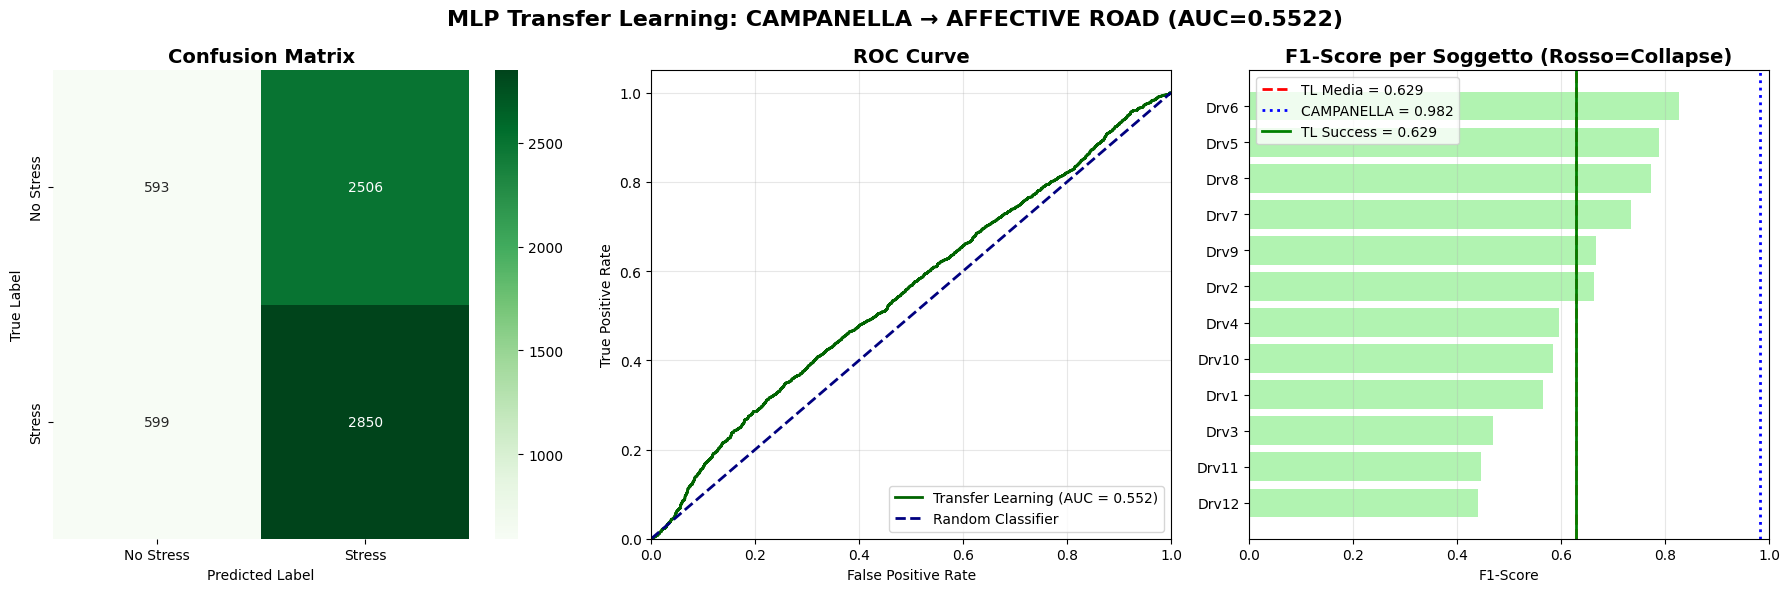


✓ Risultati salvati in:
  • Dettagli: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/CAMPANELLA_TO_AFFECTIVEROAD/mlp_transfer_learning_results.csv
  • Summary: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/CAMPANELLA_TO_AFFECTIVEROAD/mlp_transfer_learning_summary.json

TRANSFER LEARNING MLP COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING MLP: CAMPANELLA → AFFECTIVE ROAD (VISUALIZZAZIONI RIDOTTE)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO MLP CAMPANELLA
# =============================================================================

def load_campanella_mlp():
    """Carica il miglior modello MLP da CAMPANELLA"""
    model_dir = "/content/drive/MyDrive/BEST_MODELS/CAMPANELLA/MLP"

    model_path = os.path.join(model_dir, "mlp_best_loso_model.keras")
    scaler_path = os.path.join(model_dir, "mlp_best_loso_scaler.pkl")
    info_path = os.path.join(model_dir, "mlp_best_model_info.json")

    try:
        # Carica modello
        model = load_model(model_path)

        # Carica scaler
        scaler = joblib.load(scaler_path)

        # Carica info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ MLP CAMPANELLA caricato")
        print(f"  F1-Score originale: {info['f1_score']:.4f}")
        print(f"  Miglior soggetto: {info['subject']}")
        print(f"  Architettura: {len(model.layers)} layer")

        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento MLP CAMPANELLA: {e}")
        return None, None, None

# Carica modello MLP CAMPANELLA
campanella_mlp, campanella_scaler, campanella_info = load_campanella_mlp()

if campanella_mlp is None:
    print("[ERROR] Impossibile procedere senza modello MLP CAMPANELLA!")
    exit()

# =============================================================================
# SETUP DATI AFFECTIVE ROAD PER TRANSFER LEARNING
# =============================================================================

# Prepara dati AFFECTIVE ROAD
X_affectiveroad = df.drop(columns=['label', 'subject']).values
y_affectiveroad = df['label'].values
groups_affectiveroad = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP: CAMPANELLA → AFFECTIVE ROAD")
print(f"{'='*70}")
print(f"Dataset AFFECTIVE ROAD: {len(X_affectiveroad)} campioni, {X_affectiveroad.shape[1]} features, {len(np.unique(groups_affectiveroad))} soggetti")

# =============================================================================
# PARAMETRI TRANSFER LEARNING
# =============================================================================

# Parametri ottimali per evitare overfitting e class collapse
TL_EPOCHS = 10           # Epoche limitate per fine-tuning
TL_LR = 0.0001          # Learning rate molto basso
TL_BATCH_SIZE = 16      # Batch size piccolo
TL_PATIENCE = 5         # Patience per early stopping

print(f"Parametri TL: {TL_EPOCHS} epoche max, LR={TL_LR}, Batch={TL_BATCH_SIZE}")

# =============================================================================
# TRANSFER LEARNING LOSO
# =============================================================================

# Risultati per questo esperimento
transfer_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

print("\nInizio Transfer Learning LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_affectiveroad, y_affectiveroad, groups_affectiveroad)):
    subject = groups_affectiveroad[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepara dati
    X_train, X_test = X_affectiveroad[train_idx], X_affectiveroad[test_idx]
    y_train, y_test = y_affectiveroad[train_idx], y_affectiveroad[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # SCALING: Usa scaler CAMPANELLA su AFFECTIVE ROAD (SENZA refit)
    X_train_scaled = campanella_scaler.transform(X_train)
    X_test_scaled = campanella_scaler.transform(X_test)

    try:
        # === CLONE DEL MODELLO CAMPANELLA ===
        transfer_model = clone_model(campanella_mlp)
        transfer_model.set_weights(campanella_mlp.get_weights())

        # === CONGELA TUTTI I LAYER TRANNE L'ULTIMO ===
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False

        # Solo l'ultimo layer (classificazione) è trainable
        transfer_model.layers[-1].trainable = True

        print(f"Frozen layers: {len(transfer_model.layers)-1}, Trainable: 1", end=" ")

        # === CLASS WEIGHTS PER BILANCIAMENTO ===
        unique_classes = np.unique(y_train)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced',
                                               classes=unique_classes,
                                               y=y_train)
            class_weight_dict = dict(zip(unique_classes, class_weights))
        else:
            class_weight_dict = None

        # === COMPILA CON PARAMETRI CONSERVATIVI ===
        transfer_model.compile(
            optimizer=Adam(learning_rate=TL_LR, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # === CALLBACKS PER CONTROLLO TRAINING ===
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=TL_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=0
        )

        # === FINE-TUNING TRAINING ===
        history = transfer_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=TL_EPOCHS,
            batch_size=TL_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # === PREDIZIONI CON SOGLIA FISSA ===
        y_prob = transfer_model.predict(X_test_scaled, verbose=0).flatten()
        y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA, NESSUNA CORREZIONE

        # Verifica class collapse (solo per documentazione)
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            collapse_warning = " [COLLAPSE]"
        else:
            collapse_warning = ""

        # === CALCOLA METRICHE ===
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        epochs_used = len(history.history['loss'])
        print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep){collapse_warning}")

        # === SALVA RISULTATI (inclusa informazione sul collapse) ===
        transfer_results.append({
            'fold': fold + 1,
            'subject': subject,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': epochs_used,
            'predicted_classes': len(unique_pred),
            'class_collapsed': len(unique_pred) == 1
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        all_subjects.extend([subject] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# ANALISI RISULTATI E CONFRONTI
# =============================================================================

print(f"\n{'-'*60}")
print("RISULTATI TRANSFER LEARNING MLP")
print(f"{'-'*60}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['class_collapsed'] == True]
    successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
    success_rate = (len(successful_folds) / len(transfer_df)) * 100 if len(transfer_df) > 0 else 0

    print(f"Fold completati: {len(transfer_df)}")
    print(f"Fold con class collapse: {len(collapse_folds)}")
    print(f"Fold successful: {len(successful_folds)}")
    print(f"Success rate: {success_rate:.1f}%")

    if len(successful_folds) > 0:
        print(f"F1-Score medio (solo fold successful): {successful_folds['f1_score'].mean():.4f} ± {successful_folds['f1_score'].std():.4f}")
    else:
        print("ATTENZIONE: Nessun fold successful - transfer learning fallito")

    # Statistiche per soggetto
    print(f"\nRisultati dettagliati:")
    display_cols = ['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used', 'class_collapsed']
    print(transfer_df[display_cols].to_string(index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    # Confronto con CAMPANELLA originale
    print(f"\n{'-'*60}")
    print("CONFRONTO PERFORMANCE")
    print(f"{'-'*60}")

    campanella_f1 = campanella_info['f1_score']
    transfer_f1 = transfer_df['f1_score'].mean()
    improvement = transfer_f1 - campanella_f1
    improvement_pct = (improvement / campanella_f1) * 100

    print(f"CAMPANELLA F1-Score originale: {campanella_f1:.4f}")
    print(f"Transfer Learning F1:     {transfer_f1:.4f}")
    print(f"Miglioramento assoluto:   {improvement:+.4f}")
    print(f"Miglioramento relativo:   {improvement_pct:+.2f}%")

    # Range performance
    print(f"\nRange F1-Score: {transfer_df['f1_score'].min():.4f} - {transfer_df['f1_score'].max():.4f}")
    best_subject = transfer_df.loc[transfer_df['f1_score'].idxmax(), 'subject']
    worst_subject = transfer_df.loc[transfer_df['f1_score'].idxmin(), 'subject']
    print(f"Miglior soggetto: {best_subject} (F1={transfer_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {worst_subject} (F1={transfer_df['f1_score'].min():.4f})")

# =============================================================================
# METRICHE GLOBALI E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_prob = np.array(all_y_prob)

    print(f"\n{'-'*60}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*60}")

    # Verifica globale class collapse
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")

    if global_unique_pred == 1:
        print("⚠️ ATTENZIONE: Solo una classe predetta globalmente - Transfer Learning ha fallito!")
        predicted_class = all_y_pred[0]
        print(f"   Classe predetta: {predicted_class} ({'Stress' if predicted_class == 1 else 'No Stress'})")
        print("   Tutte le metriche saranno compromesse dal class collapse.")
    else:
        print("✅ Transfer Learning successful - Entrambe le classi predette")

    # Classification Report globale
    print("\nClassification Report Globale:")
    try:
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))
    except:
        print("Impossibile calcolare classification report a causa del class collapse")

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # ROC AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback - class collapse)")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (1x3 GRID)
    # =============================================================================

    print(f"\n{'-'*60}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*60}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'MLP Transfer Learning: CAMPANELLA → AFFECTIVE ROAD (AUC={roc_auc:.4f})',
                 fontsize=16, fontweight='bold')

    # 1. CONFUSION MATRIX (Left)
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. ROC CURVE (Middle)
    axes[1].plot(fpr, tpr, color='darkgreen', lw=2,
                 label=f'Transfer Learning (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO (Right)
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base al class collapse
        colors = ['red' if collapsed else 'lightgreen'
                 for collapsed in transfer_df_sorted['class_collapsed']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                       label=f'TL Media = {mean_f1_tl:.3f}')
        axes[2].axvline(x=campanella_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                       label=f'CAMPANELLA = {campanella_info["f1_score"]:.3f}')

        # Linea per media solo fold successful (se esistono)
        successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
        if len(successful_folds) > 0:
            mean_f1_successful = successful_folds['f1_score'].mean()
            axes[2].axvline(x=mean_f1_successful, color='green', linestyle='-', linewidth=2,
                           label=f'TL Success = {mean_f1_successful:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/CAMPANELLA_TO_AFFECTIVEROAD"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "mlp_transfer_learning_results.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary completo
    summary = {
        'experiment': 'MLP_Transfer_Learning',
        'source_dataset': 'CAMPANELLA',
        'target_dataset': 'AFFECTIVE ROAD',
        'source_f1': float(campanella_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'performance_improvement': float(improvement),
        'improvement_percentage': float(improvement_pct),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'success_rate': float(success_rate),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'class_collapse_folds': int(len(collapse_folds)),
        'successful_folds': int(len(successful_folds)),
        'global_classes_predicted': int(global_unique_pred),
        'parameters': {
            'epochs': TL_EPOCHS,
            'learning_rate': TL_LR,
            'batch_size': TL_BATCH_SIZE,
            'patience': TL_PATIENCE
        }
    }

    summary_path = os.path.join(save_dir, "mlp_transfer_learning_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in:")
    print(f"  • Dettagli: {results_path}")
    print(f"  • Summary: {summary_path}")

else:
    print("[WARNING] Nessun risultato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP COMPLETATO!")
print(f"{'='*70}")

VERBIO --> AFFECTIVE ROAD

In [ ]:
# =============================================================================
# CARICAMENTO MIGLIORI MODELLI VERBIO E RELATIVI SCALER
# =============================================================================

import joblib
import json
import os
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DEFINIZIONE FUNZIONI DI CARICAMENTO
# =============================================================================

def load_sklearn_model(model_dir, model_name):
    """Carica modello sklearn, scaler (opzionale) e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.pkl")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento modello (obbligatorio)
        model = joblib.load(model_path)

        # Caricamento scaler (opzionale per tree-based models)
        if os.path.exists(scaler_path):
            scaler = joblib.load(scaler_path)
            scaling_required = True
        else:
            scaler = None
            scaling_required = False
            print(f"  ⚠️  {model_name.upper()}: Scaler non trovato - Tree-based model, scaling non necessario")

        # Caricamento info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

def load_keras_model(model_dir, model_name):
    """Carica modello Keras, scaler e informazioni"""
    try:
        # Percorsi file
        model_path = os.path.join(model_dir, f"{model_name}_best_loso_model.keras")
        scaler_path = os.path.join(model_dir, f"{model_name}_best_loso_scaler.pkl")
        info_path = os.path.join(model_dir, f"{model_name}_best_model_info.json")

        # Caricamento
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)

        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ {model_name.upper()} caricato - F1: {info['f1_score']:.4f}, Soggetto: {info['subject']}")
        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento {model_name}: {e}")
        return None, None, None

# =============================================================================
# CARICAMENTO MODELLI VERBIO
# =============================================================================

print("="*60)
print("CARICAMENTO MIGLIORI MODELLI VERBIO")
print("="*60)

base_dir = "/content/drive/MyDrive/BEST_MODELS/VERBIO"

# Dizionario per memorizzare tutti i modelli
verbio_models = {}

# Modelli sklearn
sklearn_models = ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting']
for model_name in sklearn_models:
    model_dir = os.path.join(base_dir, model_name.upper())
    if os.path.exists(model_dir):
        model, scaler, info = load_sklearn_model(model_dir, model_name)
        if model is not None:
            verbio_models[model_name] = {
                'model': model,
                'scaler': scaler,
                'info': info,
                'type': 'sklearn'
            }

# Modello MLP (Keras)
mlp_dir = os.path.join(base_dir, "MLP")
if os.path.exists(mlp_dir):
    model, scaler, info = load_keras_model(mlp_dir, "mlp")
    if model is not None:
        verbio_models['mlp'] = {
            'model': model,
            'scaler': scaler,
            'info': info,
            'type': 'keras'
        }

print(f"\n✓ Totale modelli caricati: {len(verbio_models)}")
print("Modelli disponibili:", list(verbio_models.keys()))

# =============================================================================
# VERIFICA FEATURE COMPATIBILITY
# =============================================================================

print(f"\n{'-'*50}")
print("VERIFICA COMPATIBILITÀ FEATURE")
print(f"{'-'*50}")

# Verifica che le feature del dataset AFFECTIVE ROAD siano compatibili con VERBIO
affectiveroad_features = df.drop(columns=['label', 'subject']).columns
n_affectiveroad_features = len(affectiveroad_features)

print(f"Features AFFECTIVE ROAD: {n_affectiveroad_features}")

for model_name, model_data in verbio_models.items():
    try:
        if model_data['type'] == 'sklearn':
            # Per modelli sklearn, verifica n_features_in_
            expected_features = model_data['model'].n_features_in_
        elif model_data['type'] == 'keras':
            # Per modelli Keras, verifica input_shape
            expected_features = model_data['model'].input_shape[1]

        if expected_features == n_affectiveroad_features:
            print(f"✓ {model_name.upper()}: Compatible ({expected_features} features)")
        else:
            print(f"✗ {model_name.upper()}: Incompatible - Expected: {expected_features}, Got: {n_affectiveroad_features}")

    except Exception as e:
        print(f"✗ {model_name.upper()}: Error checking compatibility - {e}")

print(f"\n{'-'*50}")
print("MODELLI PRONTI PER CROSS-TEST")
print(f"{'-'*50}")

CARICAMENTO MIGLIORI MODELLI VERBIO
✓ SVM caricato - F1: 0.9429, Soggetto: P071
✓ XGB caricato - F1: 0.9796, Soggetto: P058
✓ LOGISTIC_REGRESSION caricato - F1: 0.9577, Soggetto: P071
  ⚠️  RANDOM_FOREST: Scaler non trovato - Tree-based model, scaling non necessario
✓ RANDOM_FOREST caricato - F1: 0.9062, Soggetto: P071
✓ GRADIENT_BOOSTING caricato - F1: 0.9412, Soggetto: P071
✓ MLP caricato - F1: 0.9394, Soggetto: P071

✓ Totale modelli caricati: 6
Modelli disponibili: ['svm', 'xgb', 'logistic_regression', 'random_forest', 'gradient_boosting', 'mlp']

--------------------------------------------------
VERIFICA COMPATIBILITÀ FEATURE
--------------------------------------------------
Features AFFECTIVE ROAD: 31
✓ SVM: Compatible (31 features)
✓ XGB: Compatible (31 features)
✓ LOGISTIC_REGRESSION: Compatible (31 features)
✓ RANDOM_FOREST: Compatible (31 features)
✓ GRADIENT_BOOSTING: Compatible (31 features)
✓ MLP: Compatible (31 features)

------------------------------------------------

CROSS TEST: MODELLI VERBIO → DATASET AFFECTIVE ROAD
Dataset AFFECTIVE ROAD: 6548 campioni, 31 features, 12 soggetti

⚠️  SKIPPING SVM - Noto per fallimento cross-dataset

------------------------------------------------------------
CROSS-TEST: XGB
Original F1-Score VERBIO: 0.9796
------------------------------------------------------------
Valutazione LOSO:
  Fold  1 - Drv1: F1=0.539 Acc=0.564
  Fold  2 - Drv10: F1=0.359 Acc=0.493
  Fold  3 - Drv11: F1=0.185 Acc=0.643
  Fold  4 - Drv12: F1=0.325 Acc=0.642
  Fold  5 - Drv2: F1=0.331 Acc=0.481
  Fold  6 - Drv3: F1=0.215 Acc=0.411
  Fold  7 - Drv4: F1=0.338 Acc=0.473
  Fold  8 - Drv5: F1=0.229 Acc=0.284
  Fold  9 - Drv6: F1=0.687 Acc=0.629
  Fold 10 - Drv7: F1=0.030 Acc=0.331
  Fold 11 - Drv8: F1=0.252 Acc=0.305
  Fold 12 - Drv9: F1=0.000 Acc=0.388

Risultati XGB:
  F1-Score medio: 0.2909 ± 0.1913
  Accuracy media: 0.4704 ± 0.1299

Classification Report Globale - XGB:
              precision    recall  f1-score   support

   No Stress    

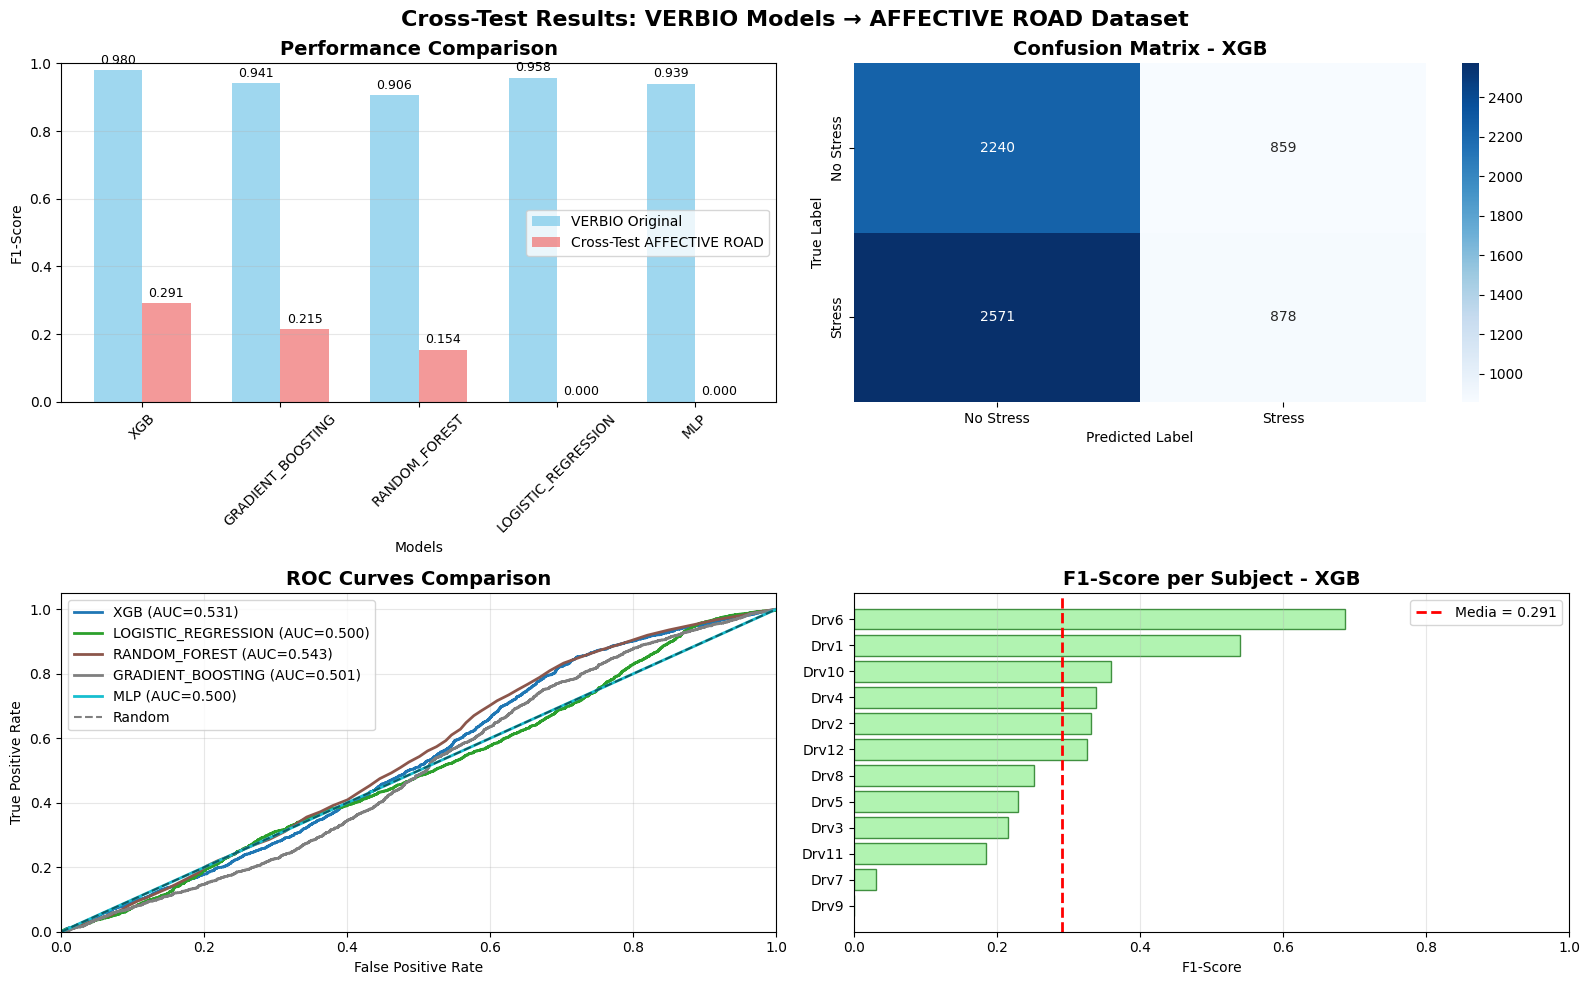


------------------------------------------------------------
ANALISI DISTRIBUZIONE PREDIZIONI
------------------------------------------------------------

XGB:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=73.47%, Stress=26.53%
  Campioni totali: 6548 (No-Stress: 4811, Stress: 1737)

LOGISTIC_REGRESSION:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=100.00%, Stress=0.00%
  Campioni totali: 6548 (No-Stress: 6548, Stress: 0)

RANDOM_FOREST:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=88.78%, Stress=11.22%
  Campioni totali: 6548 (No-Stress: 5813, Stress: 735)

GRADIENT_BOOSTING:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Stress=79.72%, Stress=20.28%
  Campioni totali: 6548 (No-Stress: 5220, Stress: 1328)

MLP:
  Distribuzione reale:    No-Stress=47.33%, Stress=52.67%
  Distribuzione predetta: No-Str

In [ ]:
# =============================================================================
# CROSS TEST: MODELLI VERBIO → DATASET AFFECTIVE ROAD CON SOGLIA FISSA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# SETUP DATI AFFECTIVE ROAD PER CROSS-TEST
# =============================================================================

# Prepara dati AFFECTIVE ROAD
X_affectiveroad = df.drop(columns=['label', 'subject']).values
y_affectiveroad = df['label'].values
groups_affectiveroad = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print("="*70)
print("CROSS TEST: MODELLI VERBIO → DATASET AFFECTIVE ROAD")
print("="*70)
print(f"Dataset AFFECTIVE ROAD: {len(X_affectiveroad)} campioni, {X_affectiveroad.shape[1]} features, {len(np.unique(groups_affectiveroad))} soggetti")

# =============================================================================
# FUNZIONE PER CROSS-TEST CON CALIBRAZIONE SOGLIE
# =============================================================================

# =============================================================================
# FUNZIONE PER CROSS-TEST CON SOGLIA FISSA
# =============================================================================

def cross_test_model(model_name, model_data, X, y, groups, logo):
    """Esegue cross-test di un singolo modello con LOSO"""

    print(f"\n{'-'*60}")
    print(f"CROSS-TEST: {model_name.upper()}")
    print(f"Original F1-Score VERBIO: {model_data['info']['f1_score']:.4f}")
    print(f"{'-'*60}")

    model = model_data['model']
    scaler = model_data['scaler']
    model_type = model_data['type']

    # Risultati per questo modello
    fold_results = []
    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    print("Valutazione LOSO:")

    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
        subject = groups[test_idx[0]]
        print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

        # Dati di test
        X_test = X[test_idx]
        y_test = y[test_idx]

        # Skip se una sola classe nel test set
        if len(np.unique(y_test)) < 2:
            print("SKIP (una sola classe)")
            continue

        # Scaling con scaler VERBIO (senza refit!) - opzionale per tree-based models
        if scaler is not None:
            X_test_scaled = scaler.transform(X_test)
        else:
            # Per modelli tree-based che non richiedono scaling
            X_test_scaled = X_test

        try:
            # Predizione in base al tipo di modello con SOGLIA FISSA 0.5
            if model_type == 'sklearn':
                y_pred = model.predict(X_test_scaled)

                # Probabilità se disponibili
                if hasattr(model, 'predict_proba'):
                    y_prob = model.predict_proba(X_test_scaled)[:, 1]
                elif hasattr(model, 'decision_function'):
                    # Per SVM senza probability=True
                    decision_scores = model.decision_function(X_test_scaled)
                    # Normalizza tra 0 e 1 usando sigmoid
                    y_prob = 1 / (1 + np.exp(-decision_scores))
                else:
                    y_prob = y_pred.astype(float)  # Fallback

            elif model_type == 'keras':
                y_prob = model.predict(X_test_scaled, verbose=0).flatten()
                y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA 0.5

            # Calcola metriche
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            print(f"F1={f1:.3f} Acc={acc:.3f}")

            # Salva risultati
            fold_results.append({
                'fold': fold + 1,
                'subject': subject,
                'n_samples': len(y_test),
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            })

            # Accumula per metriche globali
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)
            all_y_prob.extend(y_prob)

        except Exception as e:
            print(f"ERROR: {e}")
            continue

    # Calcola statistiche aggregate e mostra classification report
    if fold_results:
        results_df = pd.DataFrame(fold_results)

        print(f"\nRisultati {model_name.upper()}:")
        print(f"  F1-Score medio: {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
        print(f"  Accuracy media: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")

        # CLASSIFICATION REPORT GLOBALE per questo modello
        print(f"\nClassification Report Globale - {model_name.upper()}:")
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))

        # Performance drop rispetto a VERBIO
        performance_drop = model_data['info']['f1_score'] - results_df['f1_score'].mean()
        print(f"  Performance drop: {performance_drop:+.4f}")

        return {
            'model_name': model_name,
            'fold_results': fold_results,
            'results_df': results_df,
            'all_y_true': np.array(all_y_true),
            'all_y_pred': np.array(all_y_pred),
            'all_y_prob': np.array(all_y_prob),
            'original_f1': model_data['info']['f1_score'],
            'cross_test_f1': results_df['f1_score'].mean(),
            'performance_drop': performance_drop
        }
    else:
        print(f"Nessun risultato per {model_name}")
        return None

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

# =============================================================================
# ESECUZIONE CROSS-TEST SU TUTTI I MODELLI (ESCLUDE SVM)
# =============================================================================

cross_test_results = {}

# Lista modelli da escludere dal cross-test per problemi di generalizzazione
excluded_models = ['svm']  # SVM escluso per predizioni mono-classe sistematiche

for model_name, model_data in verbio_models.items():
    if model_name in excluded_models:
        print(f"\n⚠️  SKIPPING {model_name.upper()} - Noto per fallimento cross-dataset")
        continue

    try:
        result = cross_test_model(model_name, model_data, X_affectiveroad, y_affectiveroad, groups_affectiveroad, logo)
        if result is not None:
            cross_test_results[model_name] = result
    except Exception as e:
        print(f"Errore generale cross-test {model_name}: {e}")
        continue

# =============================================================================
# ANALISI COMPARATIVA E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if cross_test_results:
    print(f"\n{'='*70}")
    print("ANALISI COMPARATIVA CROSS-TEST")
    print(f"{'='*70}")

    # Crea tabella comparativa
    comparison_data = []
    for model_name, result in cross_test_results.items():
        comparison_data.append({
            'Model': model_name.upper(),
            'VERBIO_F1': result['original_f1'],
            'CrossTest_F1': result['cross_test_f1'],
            'Performance_Drop': result['performance_drop'],
            'N_Subjects': len(result['results_df'])
        })

    comparison_df = pd.DataFrame(comparison_data).sort_values('CrossTest_F1', ascending=False)

    print("Tabella Comparativa Performance:")
    print(comparison_df.to_string(index=False, float_format='%.4f'))

    # Trova miglior modello cross-test
    best_model_name = comparison_df.iloc[0]['Model'].lower()
    best_result = cross_test_results[best_model_name]

    print(f"\nMiglior modello cross-test: {best_model_name.upper()}")
    print(f"F1-Score cross-test: {best_result['cross_test_f1']:.4f}")
    print(f"Performance drop: {best_result['performance_drop']:+.4f}")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (2x2 GRID)
    # =============================================================================

    print(f"\n{'-'*50}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*50}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cross-Test Results: VERBIO Models → AFFECTIVE ROAD Dataset',
                 fontsize=16, fontweight='bold')

    # 1. COMPARISON BAR CHART (Top Left)
    models = comparison_df['Model']
    verbio_scores = comparison_df['VERBIO_F1']
    crosstest_scores = comparison_df['CrossTest_F1']

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[0,0].bar(x - width/2, verbio_scores, width, label='VERBIO Original',
                         color='skyblue', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, crosstest_scores, width, label='Cross-Test AFFECTIVE ROAD',
                         color='lightcoral', alpha=0.8)

    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('F1-Score')
    axes[0,0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, axis='y')
    axes[0,0].set_ylim(0, 1)

    # Aggiungi valori sulle barre
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        axes[0,0].text(bar1.get_x() + bar1.get_width()/2., height1 + 0.01,
                      f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
        axes[0,0].text(bar2.get_x() + bar2.get_width()/2., height2 + 0.01,
                      f'{height2:.3f}', ha='center', va='bottom', fontsize=9)

    # 2. CONFUSION MATRIX del miglior modello (Top Right)
    best_y_true = best_result['all_y_true']
    best_y_pred = best_result['all_y_pred']
    best_cm = confusion_matrix(best_y_true, best_y_pred)

    sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0,1])
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('True Label')
    axes[0,1].set_xlabel('Predicted Label')

    # 3. ROC CURVES COMPARATIVE (Bottom Left)
    colors_roc = plt.cm.tab10(np.linspace(0, 1, len(cross_test_results)))

    for i, (model_name, result) in enumerate(cross_test_results.items()):
        if len(result['all_y_true']) > 0:
            fpr, tpr, _ = roc_curve(result['all_y_true'], result['all_y_prob'])
            roc_auc_model = auc(fpr, tpr)

            axes[1,0].plot(fpr, tpr, color=colors_roc[i], lw=2,
                          label=f'{model_name.upper()} (AUC={roc_auc_model:.3f})')

    axes[1,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. F1-SCORE DISTRIBUTION per miglior modello (Bottom Right)
    best_df = best_result['results_df'].sort_values('f1_score', ascending=True)

    bars = axes[1,1].barh(best_df['subject'], best_df['f1_score'],
                         color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1,1].set_xlabel('F1-Score')
    axes[1,1].set_title(f'F1-Score per Subject - {best_model_name.upper()}', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3, axis='x')

    # Linea media
    mean_f1 = best_df['f1_score'].mean()
    axes[1,1].axvline(x=mean_f1, color='red', linestyle='--', linewidth=2,
                     label=f'Media = {mean_f1:.3f}')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Mostra analisi bilanciamento per ogni modello
    print(f"\n{'-'*60}")
    print("ANALISI DISTRIBUZIONE PREDIZIONI")
    print(f"{'-'*60}")

    for model_name, result in cross_test_results.items():
        y_true = result['all_y_true']
        y_pred = result['all_y_pred']

        # Distribuzione reale
        true_counts = np.bincount(y_true, minlength=2)
        true_ratio = true_counts / len(y_true)

        # Distribuzione predetta
        pred_counts = np.bincount(y_pred, minlength=2)
        pred_ratio = pred_counts / len(y_pred)

        print(f"\n{model_name.upper()}:")
        print(f"  Distribuzione reale:    No-Stress={true_ratio[0]:.2%}, Stress={true_ratio[1]:.2%}")
        print(f"  Distribuzione predetta: No-Stress={pred_ratio[0]:.2%}, Stress={pred_ratio[1]:.2%}")
        print(f"  Campioni totali: {len(y_pred)} (No-Stress: {pred_counts[0]}, Stress: {pred_counts[1]})")

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    # Directory per salvataggio
    save_dir = "/content/drive/MyDrive/CROSS_TEST_RESULTS/VERBIO_TO_AFFECTIVEROAD"
    os.makedirs(save_dir, exist_ok=True)

    # Salva tabella comparativa
    comparison_path = os.path.join(save_dir, "verbio_to_affectiveroad_comparison.csv")
    comparison_df.to_csv(comparison_path, index=False)

    # Salva dettagli per ogni modello
    for model_name, result in cross_test_results.items():
        model_path = os.path.join(save_dir, f"{model_name}_detailed_results.csv")
        result['results_df'].to_csv(model_path, index=False)

    # Salva summary JSON
    summary = {
        'source_dataset': 'VERBIO',
        'target_dataset': 'AFFECTIVE ROAD',
        'method': 'cross_test_fixed_threshold',
        'best_model': best_model_name,
        'best_crosstest_f1': float(best_result['cross_test_f1']),
        'average_performance_drop': float(comparison_df['Performance_Drop'].mean()),
        'models_tested': list(cross_test_results.keys()),
        'excluded_models': excluded_models,
        'n_subjects': len(np.unique(groups_affectiveroad))
    }

    summary_path = os.path.join(save_dir, "cross_test_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in: {save_dir}")
    print(f"  • Comparazione: {comparison_path}")
    print(f"  • Summary: {summary_path}")
    print(f"  • Dettagli per modello: {len(cross_test_results)} file CSV")

else:
    print("Nessun risultato cross-test disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("CROSS-TEST COMPLETATO!")
print(f"{'='*70}")

TRANSFER LEARNING MLP VERBIO

✓ MLP VERBIO caricato
  F1-Score originale: 0.9394
  Miglior soggetto: P071
  Architettura: 16 layer

TRANSFER LEARNING MLP: VERBIO → AFFECTIVE ROAD
Dataset AFFECTIVE ROAD: 6548 campioni, 31 features, 12 soggetti
Parametri TL: 10 epoche max, LR=0.0001, Batch=16

Inizio Transfer Learning LOSO:
  Fold  1 - Drv1: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.647 (10ep) [COLLAPSE]
  Fold  2 - Drv10: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.526 (10ep) [COLLAPSE]
  Fold  3 - Drv11: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.696 (10ep) [COLLAPSE]
  Fold  4 - Drv12: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.653 (10ep) [COLLAPSE]
  Fold  5 - Drv2: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.514 (10ep) [COLLAPSE]
  Fold  6 - Drv3: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.445 (10ep) [COLLAPSE]
  Fold  7 - Drv4: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.527 (10ep) [COLLAPSE]
  Fold  8 - Drv5: Frozen layers: 15, Trainable: 1 F1=0.000 Acc=0.292 (10ep) [COLLAPSE]
  Fold 

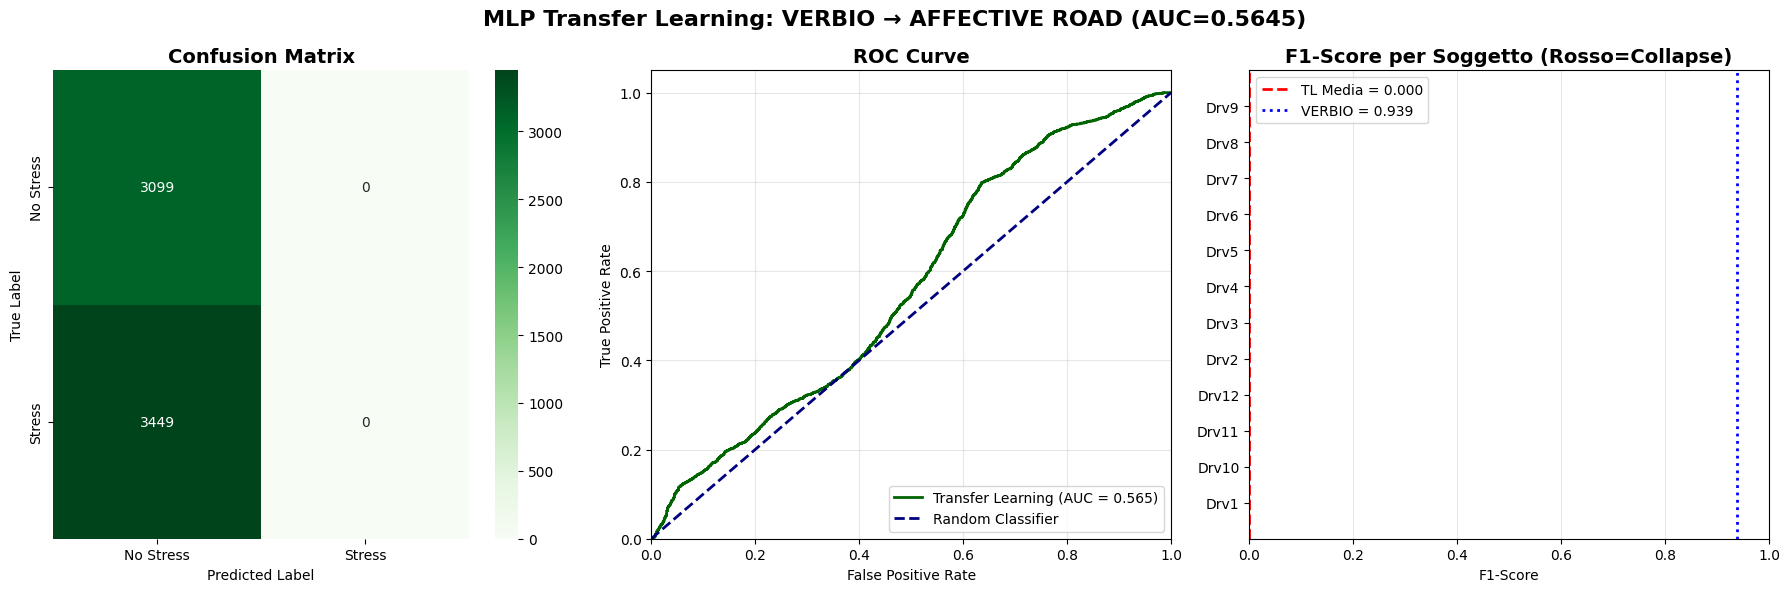


✓ Risultati salvati in:
  • Dettagli: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/VERBIO_TO_AFFECTIVEROAD/mlp_transfer_learning_results.csv
  • Summary: /content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/VERBIO_TO_AFFECTIVEROAD/mlp_transfer_learning_summary.json

TRANSFER LEARNING MLP COMPLETATO!


In [ ]:
# =============================================================================
# TRANSFER LEARNING MLP: VERBIO → AFFECTIVE ROAD (VISUALIZZAZIONI RIDOTTE)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CARICAMENTO MIGLIOR MODELLO MLP VERBIO
# =============================================================================

def load_verbio_mlp():
    """Carica il miglior modello MLP da VERBIO"""
    model_dir = "/content/drive/MyDrive/BEST_MODELS/VERBIO/MLP"

    model_path = os.path.join(model_dir, "mlp_best_loso_model.keras")
    scaler_path = os.path.join(model_dir, "mlp_best_loso_scaler.pkl")
    info_path = os.path.join(model_dir, "mlp_best_model_info.json")

    try:
        # Carica modello
        model = load_model(model_path)

        # Carica scaler
        scaler = joblib.load(scaler_path)

        # Carica info
        with open(info_path, 'r') as f:
            info = json.load(f)

        print(f"✓ MLP VERBIO caricato")
        print(f"  F1-Score originale: {info['f1_score']:.4f}")
        print(f"  Miglior soggetto: {info['subject']}")
        print(f"  Architettura: {len(model.layers)} layer")

        return model, scaler, info

    except Exception as e:
        print(f"✗ Errore caricamento MLP VERBIO: {e}")
        return None, None, None

# Carica modello MLP VERBIO
verbio_mlp, verbio_scaler, verbio_info = load_verbio_mlp()

if verbio_mlp is None:
    print("[ERROR] Impossibile procedere senza modello MLP VERBIO!")
    exit()

# =============================================================================
# SETUP DATI AFFECTIVE ROAD PER TRANSFER LEARNING
# =============================================================================

# Prepara dati AFFECTIVE ROAD
X_affectiveroad = df.drop(columns=['label', 'subject']).values
y_affectiveroad = df['label'].values
groups_affectiveroad = df['subject'].values

# Setup LOSO
logo = LeaveOneGroupOut()

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP: VERBIO → AFFECTIVE ROAD")
print(f"{'='*70}")
print(f"Dataset AFFECTIVE ROAD: {len(X_affectiveroad)} campioni, {X_affectiveroad.shape[1]} features, {len(np.unique(groups_affectiveroad))} soggetti")

# =============================================================================
# PARAMETRI TRANSFER LEARNING
# =============================================================================

# Parametri ottimali per evitare overfitting e class collapse
TL_EPOCHS = 10           # Epoche limitate per fine-tuning
TL_LR = 0.0001          # Learning rate molto basso
TL_BATCH_SIZE = 16      # Batch size piccolo
TL_PATIENCE = 5         # Patience per early stopping

print(f"Parametri TL: {TL_EPOCHS} epoche max, LR={TL_LR}, Batch={TL_BATCH_SIZE}")

# =============================================================================
# TRANSFER LEARNING LOSO
# =============================================================================

# Risultati per questo esperimento
transfer_results = []
all_y_true = []
all_y_pred = []
all_y_prob = []
all_subjects = []

print("\nInizio Transfer Learning LOSO:")

for fold, (train_idx, test_idx) in enumerate(logo.split(X_affectiveroad, y_affectiveroad, groups_affectiveroad)):
    subject = groups_affectiveroad[test_idx[0]]
    print(f"  Fold {fold+1:2d} - {subject:3s}: ", end="")

    # Prepara dati
    X_train, X_test = X_affectiveroad[train_idx], X_affectiveroad[test_idx]
    y_train, y_test = y_affectiveroad[train_idx], y_affectiveroad[test_idx]

    # Skip se una sola classe nel test set
    if len(np.unique(y_test)) < 2:
        print("SKIP (una sola classe)")
        continue

    # SCALING: Usa scaler VERBIO su AFFECTIVE ROAD (SENZA refit)
    X_train_scaled = verbio_scaler.transform(X_train)
    X_test_scaled = verbio_scaler.transform(X_test)

    try:
        # === CLONE DEL MODELLO VERBIO ===
        transfer_model = clone_model(verbio_mlp)
        transfer_model.set_weights(verbio_mlp.get_weights())

        # === CONGELA TUTTI I LAYER TRANNE L'ULTIMO ===
        for layer in transfer_model.layers[:-1]:
            layer.trainable = False

        # Solo l'ultimo layer (classificazione) è trainable
        transfer_model.layers[-1].trainable = True

        print(f"Frozen layers: {len(transfer_model.layers)-1}, Trainable: 1", end=" ")

        # === CLASS WEIGHTS PER BILANCIAMENTO ===
        unique_classes = np.unique(y_train)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced',
                                               classes=unique_classes,
                                               y=y_train)
            class_weight_dict = dict(zip(unique_classes, class_weights))
        else:
            class_weight_dict = None

        # === COMPILA CON PARAMETRI CONSERVATIVI ===
        transfer_model.compile(
            optimizer=Adam(learning_rate=TL_LR, clipnorm=1.0),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # === CALLBACKS PER CONTROLLO TRAINING ===
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=TL_PATIENCE,
            restore_best_weights=True,
            verbose=0,
            min_delta=0.001
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=0
        )

        # === FINE-TUNING TRAINING ===
        history = transfer_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=TL_EPOCHS,
            batch_size=TL_BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        # === PREDIZIONI CON SOGLIA FISSA ===
        y_prob = transfer_model.predict(X_test_scaled, verbose=0).flatten()
        y_pred = (y_prob > 0.5).astype(int)  # SOGLIA FISSA, NESSUNA CORREZIONE

        # Verifica class collapse (solo per documentazione)
        unique_pred = np.unique(y_pred)
        if len(unique_pred) == 1:
            collapse_warning = " [COLLAPSE]"
        else:
            collapse_warning = ""

        # === CALCOLA METRICHE ===
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        epochs_used = len(history.history['loss'])
        print(f"F1={f1:.3f} Acc={acc:.3f} ({epochs_used}ep){collapse_warning}")

        # === SALVA RISULTATI (inclusa informazione sul collapse) ===
        transfer_results.append({
            'fold': fold + 1,
            'subject': subject,
            'n_samples': len(y_test),
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'epochs_used': epochs_used,
            'predicted_classes': len(unique_pred),
            'class_collapsed': len(unique_pred) == 1
        })

        # Accumula per metriche globali
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        all_subjects.extend([subject] * len(y_test))

        # Pulizia memoria
        del transfer_model, history
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"ERROR: {e}")
        continue

# =============================================================================
# ANALISI RISULTATI E CONFRONTI
# =============================================================================

print(f"\n{'-'*60}")
print("RISULTATI TRANSFER LEARNING MLP")
print(f"{'-'*60}")

if transfer_results:
    transfer_df = pd.DataFrame(transfer_results)

    # Analisi class collapse
    collapse_folds = transfer_df[transfer_df['class_collapsed'] == True]
    successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
    success_rate = (len(successful_folds) / len(transfer_df)) * 100 if len(transfer_df) > 0 else 0

    print(f"Fold completati: {len(transfer_df)}")
    print(f"Fold con class collapse: {len(collapse_folds)}")
    print(f"Fold successful: {len(successful_folds)}")
    print(f"Success rate: {success_rate:.1f}%")

    if len(successful_folds) > 0:
        print(f"F1-Score medio (solo fold successful): {successful_folds['f1_score'].mean():.4f} ± {successful_folds['f1_score'].std():.4f}")
    else:
        print("ATTENZIONE: Nessun fold successful - transfer learning fallito")

    # Statistiche per soggetto
    print(f"\nRisultati dettagliati:")
    display_cols = ['subject', 'n_samples', 'accuracy', 'precision', 'recall', 'f1_score', 'epochs_used', 'class_collapsed']
    print(transfer_df[display_cols].to_string(index=False, float_format='%.4f'))

    # Statistiche aggregate
    print(f"\nStatistiche aggregate transfer learning:")
    print(f"F1-Score medio:  {transfer_df['f1_score'].mean():.4f} ± {transfer_df['f1_score'].std():.4f}")
    print(f"Accuracy media:  {transfer_df['accuracy'].mean():.4f} ± {transfer_df['accuracy'].std():.4f}")
    print(f"Precision media: {transfer_df['precision'].mean():.4f} ± {transfer_df['precision'].std():.4f}")
    print(f"Recall medio:    {transfer_df['recall'].mean():.4f} ± {transfer_df['recall'].std():.4f}")
    print(f"Epoche medie:    {transfer_df['epochs_used'].mean():.1f}")

    # Confronto con VERBIO originale
    print(f"\n{'-'*60}")
    print("CONFRONTO PERFORMANCE")
    print(f"{'-'*60}")

    verbio_f1 = verbio_info['f1_score']
    transfer_f1 = transfer_df['f1_score'].mean()
    improvement = transfer_f1 - verbio_f1
    improvement_pct = (improvement / verbio_f1) * 100

    print(f"VERBIO F1-Score originale: {verbio_f1:.4f}")
    print(f"Transfer Learning F1:     {transfer_f1:.4f}")
    print(f"Miglioramento assoluto:   {improvement:+.4f}")
    print(f"Miglioramento relativo:   {improvement_pct:+.2f}%")

    # Range performance
    print(f"\nRange F1-Score: {transfer_df['f1_score'].min():.4f} - {transfer_df['f1_score'].max():.4f}")
    best_subject = transfer_df.loc[transfer_df['f1_score'].idxmax(), 'subject']
    worst_subject = transfer_df.loc[transfer_df['f1_score'].idxmin(), 'subject']
    print(f"Miglior soggetto: {best_subject} (F1={transfer_df['f1_score'].max():.4f})")
    print(f"Peggiore soggetto: {worst_subject} (F1={transfer_df['f1_score'].min():.4f})")

# =============================================================================
# METRICHE GLOBALI E VISUALIZZAZIONI RIDOTTE
# =============================================================================

if len(all_y_true) > 0:
    # Converti in array numpy
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_prob = np.array(all_y_prob)

    print(f"\n{'-'*60}")
    print("METRICHE GLOBALI TRANSFER LEARNING")
    print(f"{'-'*60}")

    # Verifica globale class collapse
    global_unique_pred = len(np.unique(all_y_pred))
    print(f"Classi predette globalmente: {global_unique_pred}")

    if global_unique_pred == 1:
        print("⚠️ ATTENZIONE: Solo una classe predetta globalmente - Transfer Learning ha fallito!")
        predicted_class = all_y_pred[0]
        print(f"   Classe predetta: {predicted_class} ({'Stress' if predicted_class == 1 else 'No Stress'})")
        print("   Tutte le metriche saranno compromesse dal class collapse.")
    else:
        print("✅ Transfer Learning successful - Entrambe le classi predette")

    # Classification Report globale
    print("\nClassification Report Globale:")
    try:
        print(classification_report(all_y_true, all_y_pred,
                                  target_names=['No Stress', 'Stress'],
                                  zero_division=0))
    except:
        print("Impossibile calcolare classification report a causa del class collapse")

    # Confusion Matrix globale
    cm_global = confusion_matrix(all_y_true, all_y_pred)
    print(f"\nConfusion Matrix Globale:")
    print(cm_global)

    # ROC AUC
    try:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"AUC Globale: {roc_auc:.4f}")
    except:
        roc_auc = 0.5
        print(f"AUC Globale: {roc_auc:.4f} (fallback - class collapse)")

    # =============================================================================
    # VISUALIZZAZIONI RIDOTTE (1x3 GRID)
    # =============================================================================

    print(f"\n{'-'*60}")
    print("GENERAZIONE VISUALIZZAZIONI")
    print(f"{'-'*60}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'MLP Transfer Learning: VERBIO → AFFECTIVE ROAD (AUC={roc_auc:.4f})',
                 fontsize=16, fontweight='bold')

    # 1. CONFUSION MATRIX (Left)
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Stress', 'Stress'],
                yticklabels=['No Stress', 'Stress'], ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. ROC CURVE (Middle)
    axes[1].plot(fpr, tpr, color='darkgreen', lw=2,
                 label=f'Transfer Learning (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random Classifier')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # 3. F1-SCORE PER SOGGETTO (Right)
    if transfer_results:
        transfer_df_sorted = transfer_df.sort_values('f1_score', ascending=True)

        # Colora in base al class collapse
        colors = ['red' if collapsed else 'lightgreen'
                 for collapsed in transfer_df_sorted['class_collapsed']]

        bars = axes[2].barh(transfer_df_sorted['subject'],
                           transfer_df_sorted['f1_score'],
                           color=colors, alpha=0.7)
        axes[2].set_xlabel('F1-Score')
        axes[2].set_title('F1-Score per Soggetto (Rosso=Collapse)', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')

        # Linee di riferimento
        mean_f1_tl = transfer_df['f1_score'].mean()
        axes[2].axvline(x=mean_f1_tl, color='red', linestyle='--', linewidth=2,
                       label=f'TL Media = {mean_f1_tl:.3f}')
        axes[2].axvline(x=verbio_info['f1_score'], color='blue', linestyle=':', linewidth=2,
                       label=f'VERBIO = {verbio_info["f1_score"]:.3f}')

        # Linea per media solo fold successful (se esistono)
        successful_folds = transfer_df[transfer_df['class_collapsed'] == False]
        if len(successful_folds) > 0:
            mean_f1_successful = successful_folds['f1_score'].mean()
            axes[2].axvline(x=mean_f1_successful, color='green', linestyle='-', linewidth=2,
                           label=f'TL Success = {mean_f1_successful:.3f}')

        axes[2].legend()
        axes[2].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # SALVATAGGIO RISULTATI
    # =============================================================================

    save_dir = "/content/drive/MyDrive/TRANSFER_LEARNING_RESULTS/VERBIO_TO_AFFECTIVEROAD"
    os.makedirs(save_dir, exist_ok=True)

    # Salva risultati dettagliati
    results_path = os.path.join(save_dir, "mlp_transfer_learning_results.csv")
    transfer_df.to_csv(results_path, index=False)

    # Salva summary completo
    summary = {
        'experiment': 'MLP_Transfer_Learning',
        'source_dataset': 'VERBIO',
        'target_dataset': 'AFFECTIVE ROAD',
        'source_f1': float(verbio_info['f1_score']),
        'transfer_f1_mean': float(transfer_df['f1_score'].mean()),
        'transfer_f1_std': float(transfer_df['f1_score'].std()),
        'transfer_auc': float(roc_auc),
        'performance_improvement': float(improvement),
        'improvement_percentage': float(improvement_pct),
        'avg_epochs_used': float(transfer_df['epochs_used'].mean()),
        'success_rate': float(success_rate),
        'n_subjects': len(transfer_df),
        'n_samples': int(len(all_y_true)),
        'class_collapse_folds': int(len(collapse_folds)),
        'successful_folds': int(len(successful_folds)),
        'global_classes_predicted': int(global_unique_pred),
        'parameters': {
            'epochs': TL_EPOCHS,
            'learning_rate': TL_LR,
            'batch_size': TL_BATCH_SIZE,
            'patience': TL_PATIENCE
        }
    }

    summary_path = os.path.join(save_dir, "mlp_transfer_learning_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Risultati salvati in:")
    print(f"  • Dettagli: {results_path}")
    print(f"  • Summary: {summary_path}")

else:
    print("[WARNING] Nessun risultato disponibile per la visualizzazione")

print(f"\n{'='*70}")
print("TRANSFER LEARNING MLP COMPLETATO!")
print(f"{'='*70}")